In [1]:
#from aggregation import *
import scanpy as sc
#import ndd ## for entropy

import glob
import os

import numpy as np
import anndata
#import tables
import scipy.sparse as sp
import pandas as pd
import collections
from typing import Union, Dict, Tuple, List, Callable
from collections import Counter
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import os, sys, string
import h5py
import anndata
import collections
#from harmony import harmonize
import scanpy.external as sce

#import scrublet
#from pandas.compat import map, lmap, u

In [2]:
print(anndata.__version__)
print(sc.__version__)
print(h5py.__version__)

0.10.9
1.10.3
3.12.1


In [3]:
def find_markers_filter(adata, 
                                     res: float = 1.5, 
                                     n_neighbors: int = 50, 
                                     min_in_group_fraction=0.1,
                                     max_out_group_fraction=0.5,
                                     min_log_fold_change=1.,
                                     mygroupby: str = "cluster",
                                     verbose: bool = True):
    """This preserves the adata.raw slot with CellRanger raw data."""
    
    # make a copy
    tmp_copy_adata = adata.copy()
    #print(adata.raw.var_names)
    print(adata.var_names)
    print(tmp_copy_adata.var_names)
    del tmp_copy_adata.raw
    
    print(tmp_copy_adata.var.head())
    #sys.exit()

    if verbose:
        print('Normalizing data')
    sc.pp.normalize_total(tmp_copy_adata)
    
    if verbose:
        print('Log scaling data')
    sc.pp.log1p(tmp_copy_adata)
    
    if 'rank_genes_groups' + str(res) not in tmp_copy_adata.obs.keys():
        if verbose:
            print('Finding marker genes')
        sc.tl.rank_genes_groups(tmp_copy_adata,
                                groupby=mygroupby,
                                key_added='rank_genes_groups_' + mygroupby,
                                method='wilcoxon',
                                use_raw=False)
    
    if verbose:
        print('Filtering marker genes')
    sc.tl.filter_rank_genes_groups(tmp_copy_adata,
                                   groupby=mygroupby,
                                   key='rank_genes_groups_' + mygroupby,
                                   key_added='filter_rank_genes_groups_' + mygroupby,
                                   min_in_group_fraction=min_in_group_fraction,
                                   min_fold_change=min_log_fold_change,
                                   max_out_group_fraction=max_out_group_fraction,
                                   use_raw=False)
    
    # copy back over to adata
    try:
        adata.uns['rank_genes_groups_' + mygroupby] = tmp_copy_adata.uns['rank_genes_groups_' + mygroupby]
    except:
        print('Failed in copying over rank_genes_groups data')
    try:
        adata.uns['filter_rank_genes_groups_' + mygroupby]\
        = tmp_copy_adata.uns['filter_rank_genes_groups_' + mygroupby]
    except:
        print('Failed in copying over filter_rank_genes_groups data')
    
    if '__is_in_cluster__' in adata.obs.keys():
        del adata.obs['__is_in_cluster__']

    return

In [4]:
def cell_count_dotplot(adata: anndata.AnnData,
                       res: float,
                       key: str,
                       cluster_key: Union[str, None] = None,
                       normalize: str = 'column',
                       myfilename: str = 'test',
                                             show: bool = True):

    assert key in adata.obs.keys(), f'{key} is not in adata.obs'
    assert cluster_key in adata.obs.keys(), f'{cluster_key} is not in adata.obs'
    assert normalize in {'row', 'column', 'row_then_column'}
    if cluster_key is None:
        cluster_key = 'louvain' + str(res)

    counts_tissue_cluster_df = pd.crosstab(adata.obs[cluster_key],
                                           adata.obs[key])

    if normalize == 'row':
        counts_tissue_cluster_df = counts_tissue_cluster_df.div(counts_tissue_cluster_df.sum(axis=0),
                                                                axis=1)  # row normalize
    elif normalize == 'column':
        counts_tissue_cluster_df = counts_tissue_cluster_df.div(counts_tissue_cluster_df.sum(axis=1),
                                                                axis=0)  # column normalize
    elif normalize == 'row_then_column':
        counts_tissue_cluster_df = counts_tissue_cluster_df.div(counts_tissue_cluster_df.sum(axis=0),
                                                                axis=1)  # row normalize
        counts_tissue_cluster_df = counts_tissue_cluster_df.div(counts_tissue_cluster_df.sum(axis=1),
                                                                axis=0)  # column normalize
    else:
        raise ValueError(f'normalize must be in ["row", "column", "row_then_column"] but was {normalize}')

    scatter_df = counts_tissue_cluster_df.stack().rename_axis(['y', 'x']).reset_index(name='val')

    counts = pd.crosstab(adata.obs[cluster_key],
                         adata.obs[key]).sum(axis=1).values.tolist()

    y = scatter_df['x'].values
    x = scatter_df['y'].values
    s = scatter_df['val'].values * 500

    plt.figure(figsize=(adata.obs[cluster_key].unique().size * 3 / 5,
                        adata.obs[key].unique().size / 2))
    plt.scatter(x, y, s=s, marker='s')
    plt.ylabel(key)
    plt.xlabel('Cluster label')
    ax1 = plt.gca()
    ax1.grid(False)
    plt.xticks(rotation=90)

    ax2 = ax1.twiny()

    ax2.scatter(x, y, s=s, marker='s')

    ax2.set_xticklabels([str(c) for c in counts])
    plt.xticks(rotation=45)
    plt.xlabel('Cells per cluster')
    ax2.grid(False)

    if show:
        plt.show()
        
    plt.savefig(resulthome + myfilename , bbox_inches='tight')
        
    return

In [5]:
home      = "/data/ep924610/project_nb/paper_code"
datahome  = home+ "data/"
resulthome= home+ "umaps/"

In [6]:
atlas_files = "/data/Kramann_lab/From_Leon/3CA_anndatas/"

In [7]:
adata    = sc.read_h5ad(atlas_files + 'human_skin_ts_after_batcheffect_corrected.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 136744 × 12661
    obs: 'donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'scvi_leiden_res05_tissue', 'sample_number', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'disease_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tis

In [9]:
adata.obs[['sample', 'patient']].drop_duplicates().sort_values(by="patient")

sample patient
0-0-1                  2586-4_Tumor_Before  2586-4
2243-0-1   2586-4_Tumor_AcquiredResistance  2586-4
26053-0-1                     9245-3_Tumor  9245-3
2-3-1                             MBM01_sc   MBM01
3515-3-1                          MBM02_sc   MBM02
...                                    ...     ...
21398-2-1                               P6     NaN
28062-2-1                               P7     NaN
33646-2-1                               P8     NaN
37079-2-1                               P9     NaN
43597-2-1                              P10     NaN

[114 rows x 2 columns]

In [10]:
print(adata[:,'GPNMB'].X.todense())

[[ 0.]
 [ 0.]
 [ 0.]
 ...
 [ 1.]
 [37.]
 [ 0.]]


In [11]:
adata[adata.obs['sample'].isna()].obs.head()#[['sample', 'patient']]#.drop_duplicates().sort_values(by="patient")

Empty DataFrame
Columns: [donor_id, tissue_in_publication, anatomical_position, method, cdna_plate, library_plate, notes, cdna_well, assay_ontology_term_id, sample_id, replicate, 10X_run, ambient_removal, donor_method, donor_assay, donor_tissue, donor_tissue_assay, cell_type_ontology_term_id, compartment, broad_cell_class, free_annotation, manually_annotated, published_2022, n_genes_by_counts, total_counts, total_counts_mt, pct_counts_mt, total_counts_ercc, pct_counts_ercc, _scvi_batch, _scvi_labels, scvi_leiden_donorassay_full, ethnicity_original, scvi_leiden_res05_tissue, sample_number, organism_ontology_term_id, suspension_type, tissue_type, disease_ontology_term_id, is_primary_data, tissue_ontology_term_id, sex_ontology_term_id, self_reported_ethnicity_ontology_term_id, development_stage_ontology_term_id, cell_type, assay, disease, organism, sex, tissue, self_reported_ethnicity, development_stage, observation_joinid, sample, patient, source, timepoint, complexity, n_genes, file_id, amp_batch, cell_subtype, location, stage, umap1, umap2, g1s_score, g2m_score, cell_cycle_phase, mp_top_score, mp_top, mp_assignment, cell_subtype_level1, cell_subtype_level2, time_point, treatment, sort, batch, leiden0.1, leiden0.2, leiden0.3, leiden0.4, leiden0.5]
Index: []

[0 rows x 83 columns]

In [33]:
adata.obs[['sample', 'broad_cell_class']].drop_duplicates()

sample  \
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...  TSP2_Skin_Chest_SS2_B113707_B111658_ImmuneLine...   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...  TSP2_Skin_Chest_SS2_B113707_B111658_ImmuneLine...   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...  TSP2_Skin_Chest_SS2_B113707_B111658_ImmuneLine...   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...  TSP2_Skin_Chest_SS2_B113707_B111658_ImmuneLine...   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...  TSP2_Skin_Chest_SS2_B113707_B111658_ImmuneLine...   
...                                                                                               ...   
31968-4-1                                                                                   su007_pre   
36123-4-1                                                                                  su008_post   
37480-4-1                                                                                   su008_pre   
49100-4-1                                                                                  su010_post   
49681-4-1                                                                                   su010_pre   

                                                     broad_cell_class  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     dendritic cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...             t cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...     dendritic cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...  myeloid leukocyte  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...             t cell  
...                                                               ...  
31968-4-1                                                         NaN  
36123-4-1                                                         NaN  
37480-4-1                                                         NaN  
49100-4-1                                                         NaN  
49681-4-1                                                         NaN  

[304 rows x 2 columns]

In [19]:
adata.obs['broad_cell_class'].astype(str)

TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_F11-0       dendritic cell
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_D7-0                t cell
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNeg_N13-0       dendritic cell
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_D6-0     myeloid leukocyte
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_A16-0    myeloid leukocyte
                                                                ...        
40015-4-1                                                               nan
40016-4-1                                                               nan
49100-4-1                                                               nan
49145-4-1                                                               nan
49681-4-1                                                               nan
Name: broad_cell_class, Length: 136744, dtype: object

In [ ]:
adata.obs[['broad_cell_class']]

In [29]:
adata.obs['broad_cell_class']= adata.obs['broad_cell_class'].fillna('Malignant')

TypeError: Cannot setitem on a Categorical with a new category (Malignant), set the categories first

In [28]:
adata.obs['broad_cell_class'].astype(str)

TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_F11-0       dendritic cell
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_D7-0                t cell
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNeg_N13-0       dendritic cell
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_D6-0     myeloid leukocyte
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPos_A16-0    myeloid leukocyte
                                                                ...        
40015-4-1                                                               nan
40016-4-1                                                               nan
49100-4-1                                                               nan
49145-4-1                                                               nan
49681-4-1                                                               nan
Name: broad_cell_class, Length: 136744, dtype: object

In [21]:
cluster_id = "broad_cell_class"

In [36]:
# add treatment status
rz_samples    = set(['RZ_BZ', 'RZ', 'RZ_GT'])
fz_samples    = set(['FZ', 'FZ_GT', 'RZ_FZ'])
iz_samples    = set(['IZ_GT',  'GT_IZ',  'IZ','IZ_BZ'])
control_samples = set(['control'])

def get_treatment(s):
    if s == 'nan':
        return 'Malignant'
    else:
        raise ValueError(f'sample {s} not in definitions')

#adata.obs['broad_cell_class1'] = adata.obs['broad_cell_class'].apply(get_treatment).astype('category')

/tmp/ipykernel_2163269/3734690401.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pos      = df.groupby('cluster').median()


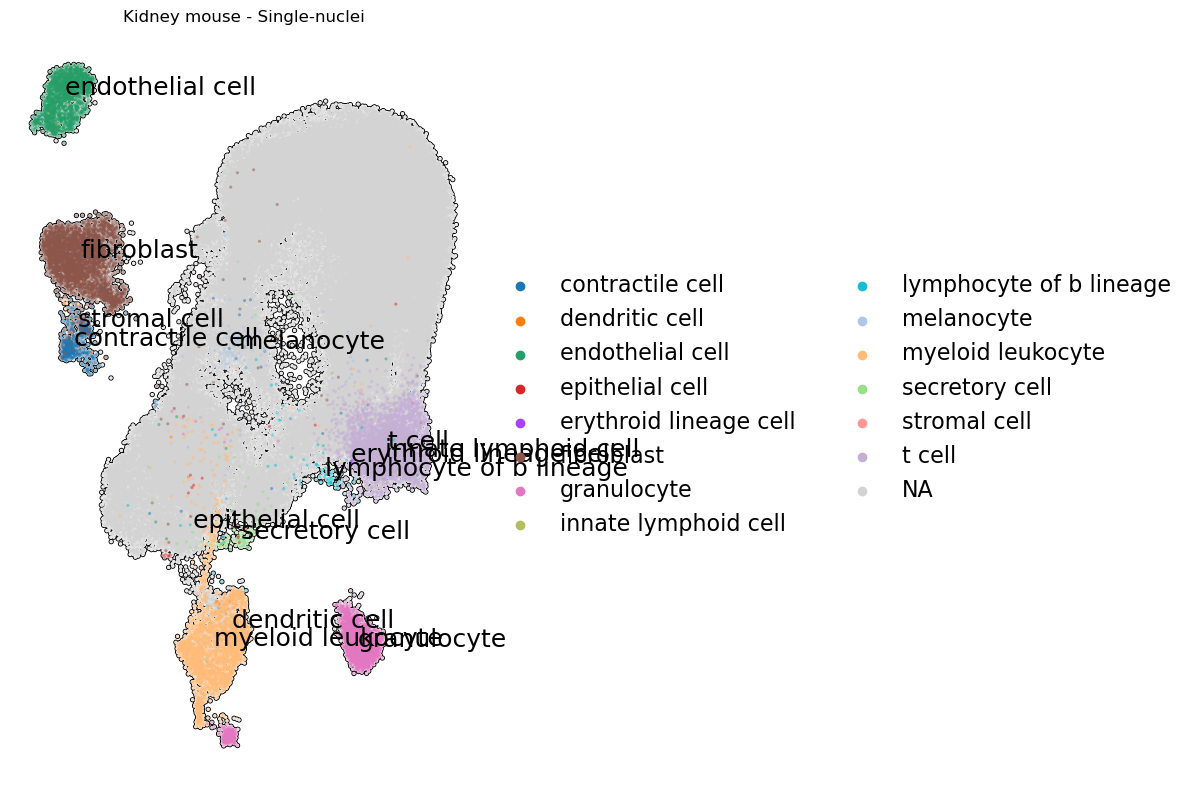

In [23]:
# show clustering with numbers

plt.figure(figsize=(12, 8))
sc.pl.embedding(adata, add_outline=True, basis='X_umap', color=cluster_id,\
                ax=plt.gca(), alpha=0.5, size=20, legend_fontsize=16,legend_fontoutline=8,\
                frameon=False, show=False)

df            = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[cluster_id].values
mean_pos      = df.groupby('cluster').median()

for c in mean_pos.index:    
    plt.gca().text(mean_pos.loc[c][0], mean_pos.loc[c][1], c.split(':')[0], 
                   fontsize=18, color='black')

plt.title('Kidney mouse - Single-nuclei')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
#plt.savefig('Kidney_ADPKD_Human_umap.pdf', bbox_inches='tight')
#plt.show()

In [26]:
adata.obs.columns

Index(['donor_id', 'tissue_in_publication', 'anatomical_position', 'method',
       'cdna_plate', 'library_plate', 'notes', 'cdna_well',
       'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run',
       'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue',
       'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment',
       'broad_cell_class', 'free_annotation', 'manually_annotated',
       'published_2022', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc',
       'pct_counts_ercc', '_scvi_batch', '_scvi_labels',
       'scvi_leiden_donorassay_full', 'ethnicity_original',
       'scvi_leiden_res05_tissue', 'sample_number',
       'organism_ontology_term_id', 'suspension_type', 'tissue_type',
       'disease_ontology_term_id', 'is_primary_data',
       'tissue_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'cell

In [27]:
adata.obs[['file_id', 'batch', 'broad_cell_class']].drop_duplicates()

file_id  \
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                          NaN   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...                          NaN   
TSP2_Skin_abdomen_SS2_B113705_B111656_Endotheli...                          NaN   
TSP2_Skin_abdomen_SS2_B113705_B111656_Epithelia...                          NaN   
TSP10_Skin_chest_SS2_B134176_B133829_ImmuneLinN...                          NaN   
TSP10_Skin_abdomen_SS2_B134175_B133830_Epitheli...                          NaN   
TSP21_Eye_OralMucosa_10X_1_1_AGCCACGTCTACTGAG-0                             NaN   
0-0-1                                                Data_Paulson2020_Skin.h5ad   
989-1-1                                                   Data_Li2019_Skin.h5ad   
0-2-1                                                     Data_Ji2020_Skin.h5ad   
2-3-1                                               Data_Biermann2022_Skin.h5ad   
10429-4-1                                                              BCC.h5ad   

                                                   batch  \
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...     0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...     0   
TSP2_Skin_abdomen_SS2_B113705_B111656_Endotheli...     0   
TSP2_Skin_abdomen_SS2_B113705_B111656_Epithelia...     0   
TSP10_Skin_chest_SS2_B134176_B133829_ImmuneLinN...     0   
TSP10_Skin_abdomen_SS2_B134175_B133830_Epitheli...     0   
TSP21_Eye_OralMucosa_10X_1_1_AGCCACGTCTACTGAG-0        0   
0-0-1                                                  1   
989-1-1                                                1   
0-2-1                                                  1   
2-3-1                                                  1   
10429-4-1                                              1   

                                                           broad_cell_class  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...           dendritic cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...                   t cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...        myeloid leukocyte  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...              granulocyte  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...     innate lymphoid cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...           secretory cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...               fibroblast  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...         contractile cell  
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...         endothelial cell  
TSP2_Skin_abdomen_SS2_B113705_B111656_Endotheli...               melanocyte  
TSP2_Skin_abdomen_SS2_B113705_B111656_Epithelia...          epithelial cell  
TSP10_Skin_chest_SS2_B134176_B133829_ImmuneLinN...  lymphocyte of b lineage  
TSP10_Skin_abdomen_SS2_B134175_B133830_Epitheli...             stromal cell  
TSP21_Eye_OralMucosa_10X_1_1_AGCCACGTCTACTGAG-0      erythroid lineage cell  
0-0-1                                   

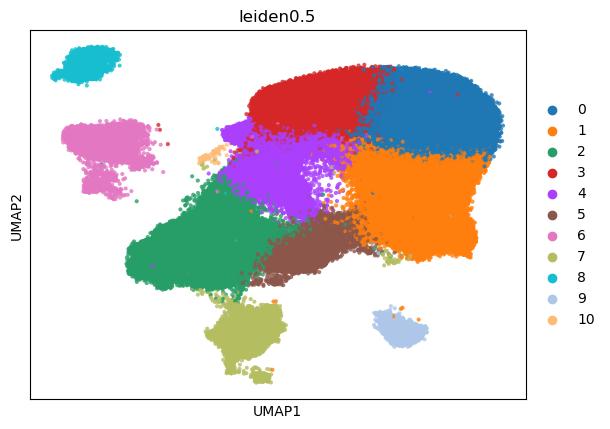

In [22]:
res = 0.5
sc.pl.embedding(adata, basis='umap', color='leiden'+str(res), ax=plt.gca(), show=True, alpha=0.8, size=35)

In [24]:
## create different UMAPs

if 0:
    
    # Copy adata not to modify UMAP in the original adata object
    adata_temp = adata.copy()
    # Loop through different umap parameters, recomputting and replotting UMAP for each of them
    for min_dist in [0.1, 1, 2]:
        for spread in [0.5, 1, 5]:
            param_str = " ".join(["min_dist =", str(min_dist), "and spread =", str(spread)])
            sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
            # Display plot and then immediately close it to ensure that
            # we do not open too many plot windows at once
            g = sc.pl.umap(
                adata_temp,
                color=["cluster_name"],
                title=param_str,
                s=40,
                show=False,
                return_fig=True,
            )
            display(g)
            plt.close()
    del adata_temp

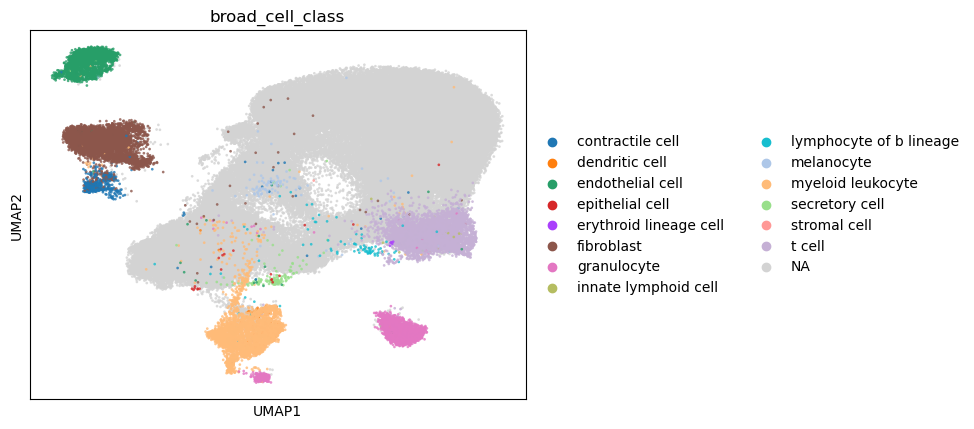

In [26]:
sc.pl.embedding(adata, basis='umap', color='broad_cell_class', ax=plt.gca(), show=True, alpha=0.8, size=15)

In [28]:
Counter(adata.obs['cell_type'])

Counter({'Malignant': 118958,
         'fibroblast': 4133,
         'macrophage': 3321,
         'T cell': 2636,
         'endothelial cell': 2076,
         'mast cell': 2001,
         'CD8-positive, alpha-beta T cell': 1531,
         'smooth muscle cell': 504,
         'CD4-positive, alpha-beta T cell': 365,
         'neutrophil': 290,
         'regulatory T cell': 273,
         'sebum secreting cell': 135,
         'myeloid dendritic cell': 108,
         'melanocyte': 106,
         'plasma cell': 86,
         'Langerhans cell': 76,
         'natural killer cell': 64,
         'mature NK T cell': 33,
         'keratocyte': 14,
         'basophil': 8,
         'epithelial cell': 8,
         'B cell': 7,
         'erythrocyte': 5,
         'stromal cell': 4,
         'activated CD4-positive, alpha-beta T cell': 1,
         'muscle cell': 1})

In [30]:
Counter(adata.obs['broad_cell_class'])

Counter({nan: 118958,
         't cell': 4839,
         'fibroblast': 4133,
         'myeloid leukocyte': 3397,
         'granulocyte': 2299,
         'endothelial cell': 2076,
         'contractile cell': 505,
         'secretory cell': 135,
         'dendritic cell': 108,
         'melanocyte': 106,
         'lymphocyte of b lineage': 93,
         'innate lymphoid cell': 64,
         'epithelial cell': 22,
         'erythroid lineage cell': 5,
         'stromal cell': 4})

/tmp/ipykernel_2095047/451715023.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([str(c) for c in counts])


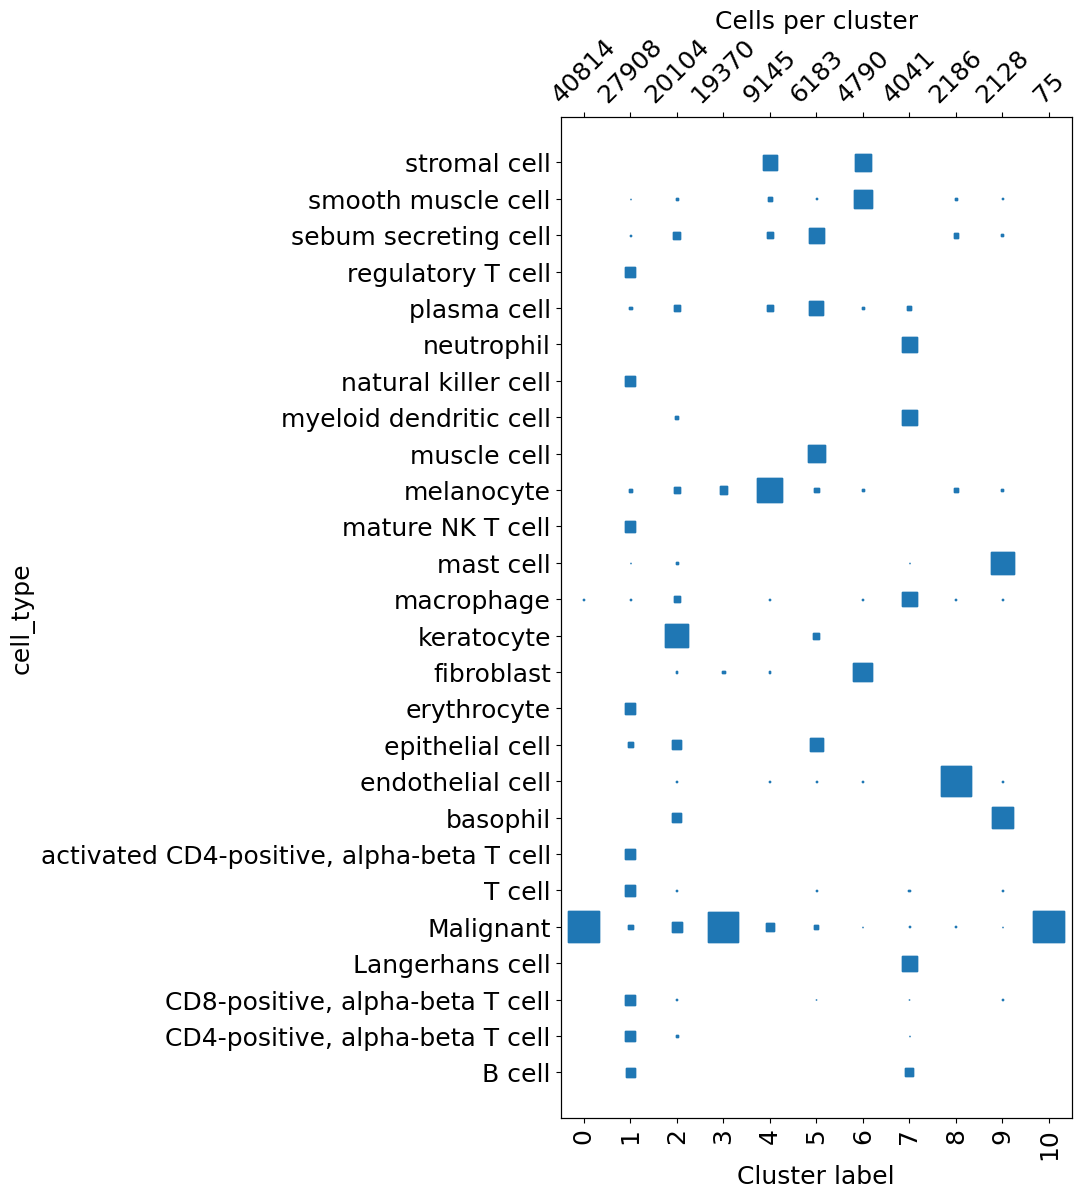

<Figure size 300x300 with 0 Axes>

In [74]:
cell_count_dotplot(adata, res=1, \
                   key='cell_type', cluster_key='leiden0.5', normalize='row_then_column')

/tmp/ipykernel_2095047/451715023.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([str(c) for c in counts])


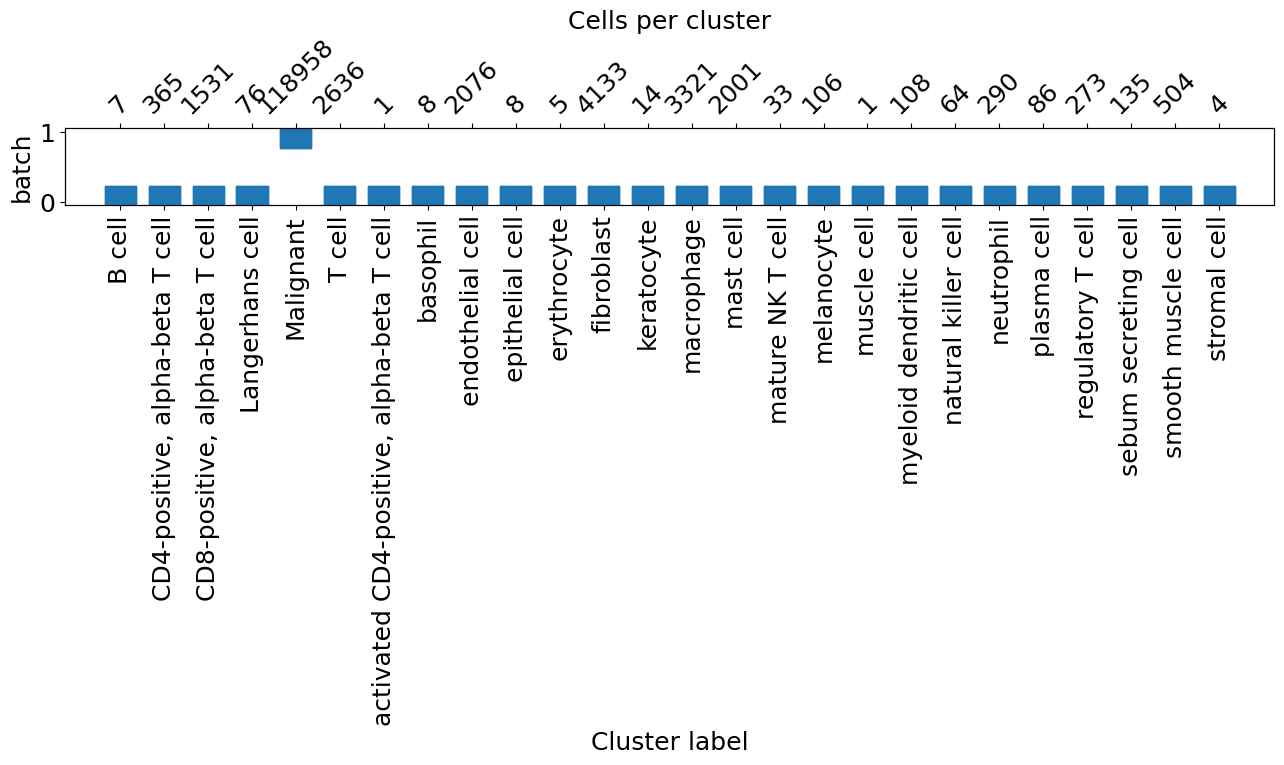

<Figure size 300x300 with 0 Axes>

In [75]:
cell_count_dotplot(adata, res=1, \
                   cluster_key='cell_type', key='batch', normalize='row_then_column')

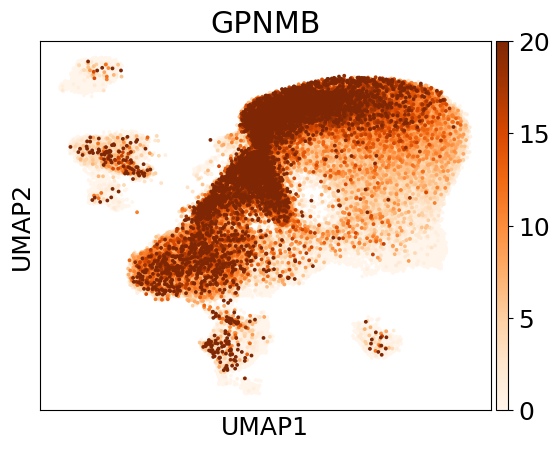

In [38]:
#sc.set_figure_params(fontsize=14)
## Plot marker genes
plt.rcParams.update({'font.size': 18})
sc.pl.embedding(adata, basis='umap', color=['GPNMB'], color_map='Oranges', size=30, ncols=3, show=False, vmax=20)
plt.savefig(resulthome+'Human_hearts_pcsk6_UMAPs.pdf', bbox_inches='tight')

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

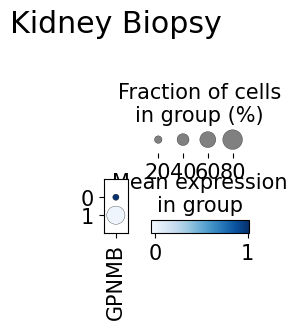

In [39]:
## Plot marker genes
plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
                  var_names=['GPNMB'], 
                  use_raw=False,
                  groupby='batch',
                  log=False,
                  standard_scale='var',
                  color_map='Blues',
                  vmin=-0.05,
                  vmax=1.01,
                  smallest_dot=5,
                  show=False, title='Kidney Biopsy')
    
#plt.savefig(resulthome+'Human_hearts_select_genes.pdf', bbox_inches='tight')

In [54]:
cluster_key = "leiden0.5"

In [55]:
find_markers_filter(adata, mygroupby=cluster_key)

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ADORA3', 'EXOC3L2', 'SCO2', 'C2orf81', 'TBCE', 'LRTOMT', 'ARHGAP11B',
       'ACTL10', 'PRRC2B', 'F8A1'],
      dtype='object', length=12661)
Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ADORA3', 'EXOC3L2', 'SCO2', 'C2orf81', 'TBCE', 'LRTOMT', 'ARHGAP11B',
       'ACTL10', 'PRRC2B', 'F8A1'],
      dtype='object', length=12661)
                ensembl_id-0     genome-0   mt-0  ercc-0  n_cells_by_counts-0  \
TSPAN6    ENSG00000000003.15  Gencode_v41  False   False               161872   
DPM1      ENSG00000000419.14  Gencode_v41  False   False               461590   
SCYL3     ENSG00000000457.14  Gencode_v41  False   False               156149   
C1orf112  ENSG00000000460.17  Gencode_v41  False   False               120250   
FGR       ENSG00000000938.13  Gencode_v41  False   False               

leiden0.5_markers.png
[['FMN1' 'MYO10' 'PRKCE' 'BNC2' 'FTX' 'SGCD' 'PTPRJ' 'EXOC4' 'TMEM117'
  'FHIT' 'DIP2C' 'SMYD3' 'MYO5A' 'RAD51B' 'PTK2' 'RERE' 'NSMCE2' 'ASAP1'
  'ARID1B' 'LYST']
 ['MALAT1' 'SLAMF1' 'PTPRC' 'CXCR4' 'CYTIP' 'RORA' 'SYTL3' 'ITK' 'CD96'
  'IL7R' 'IKZF1' 'CD53' 'CD69' 'RHOH' 'FYN' 'CD2' 'SAMSN1' 'SPOCK2'
  'CD48' 'CD3D']
 ['HSPB1' 'HSPA1A' 'RPL7' 'ACTB' 'DNAJB1' 'RPS6' 'ALDOA' 'RPLP0' 'GSTP1'
  'HSPA1B' 'UBC' 'RPL13A' 'RPL18A' 'RPL10' 'JUN' 'RPL10A' 'ACTG1' 'BTF3'
  'RPL3' 'DYNLL1']
 ['SPARC' 'SERPINE2' 'TIMP2' 'ATP1A1' 'GPNMB' 'CD63' 'CTSB' 'LGALS3BP'
  'CD81' 'PSAP' 'ITGA6' 'NRP2' 'DCBLD2' 'MFSD12' 'FRMD4A' 'PPFIBP1'
  'EHBP1' 'TNFRSF19' 'MMP14' 'SDC3']
 ['MIA' 'NME2' 'MIF' 'VIM' 'APOE' 'S100B' 'ATP6V0C' 'CD63' 'NPC2' 'RPL17'
  'CST3' 'TIMP1' 'NDUFA13' 'TMEM14C' 'S100A13' 'RNASEK' 'LGALS1' 'MRPS24'
  'SPARC' 'TRAPPC5']
 ['HMGN2' 'CHCHD2' 'STMN1' 'SUMO2' 'PRDX2' 'EEF1B2' 'PTMA' 'RPS5' 'CYCS'
  'TUBB' 'HINT1' 'KRT18' 'HNRNPA1' 'RAN' 'HSBP1' 'PPIA' 'RPS3A' 'RPL15'
  '

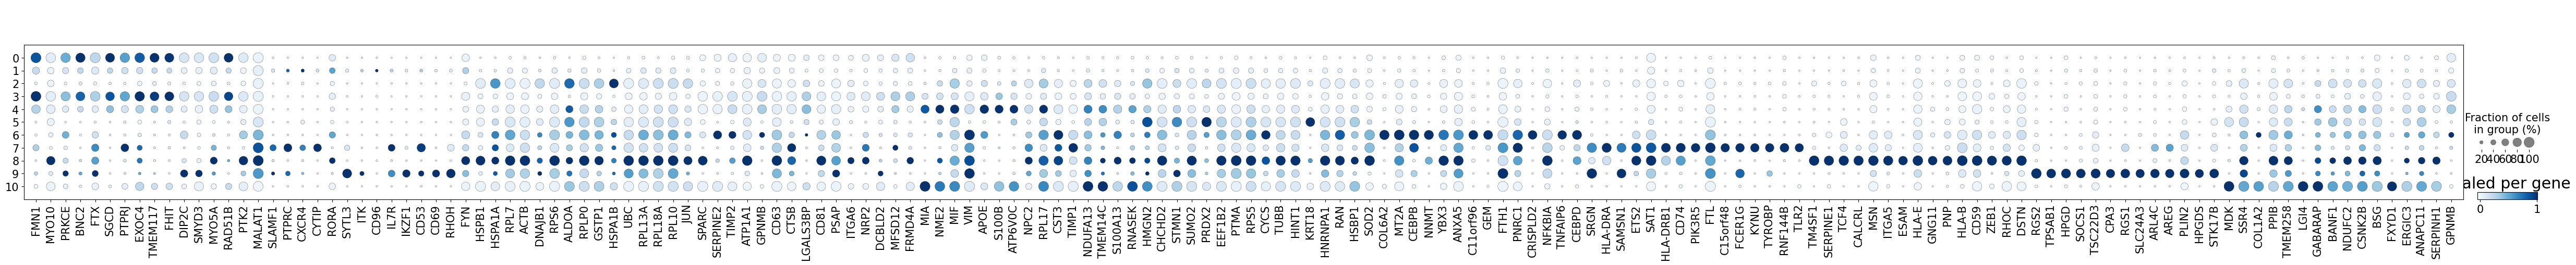

In [57]:
plt.rcParams.update({'font.size': 18})

n = 15

marker_key = 'filter_rank_genes_groups_' + cluster_key
marker_key = 'rank_genes_groups_' + cluster_key
#marker_key = "rank_genes_groups_leiden"+str(res)

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()

unique_markers = []

for k in range(marker_genes.shape[0]):
    i = 0
    for g in marker_genes[k, :]:
        if i < n and g not in unique_markers and g != 'nan' and g != 'AC134224.3':  # malat1
            unique_markers.append(g)
            i += 1

unique_markers.append('GPNMB')

sc.pl.dotplot(adata, 
              var_names=unique_markers,
              use_raw=False,
              groupby=cluster_key,
              log=False,
              standard_scale='var',
              color_map='Blues',
              vmin=-0.05,
              vmax=1.01,
              smallest_dot=5,
              show=False)#, gene_symbols="marmosets_gene_ids")

plt.title('Scaled per gene')
#plt.show()

markerfilename = cluster_key + '_markers.png'
print(markerfilename)
plt.savefig(resulthome + markerfilename, bbox_inches='tight')
#plt.show()

print(marker_genes)

In [35]:
## normalize 1st way

In [36]:
# make a copy
tmp_copy_adata = adata.copy()
sc.pp.normalize_total(tmp_copy_adata)
sc.pp.log1p(tmp_copy_adata)

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

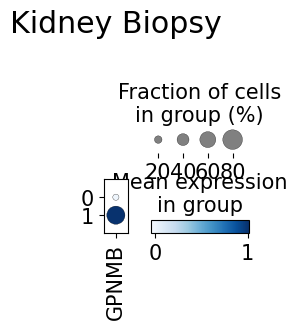

In [40]:
## Plot marker genes
plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(tmp_copy_adata, 
                  var_names=['GPNMB'], 
                  use_raw=False,
                  groupby='batch',
                  log=False,
                  standard_scale='var',
                  color_map='Blues',
                  vmin=-0.05,
                  vmax=1.01,
                  smallest_dot=5,
                  show=False, title='Kidney Biopsy')
    
#plt.savefig(resulthome+'Human_hearts_select_genes.pdf', bbox_inches='tight')

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

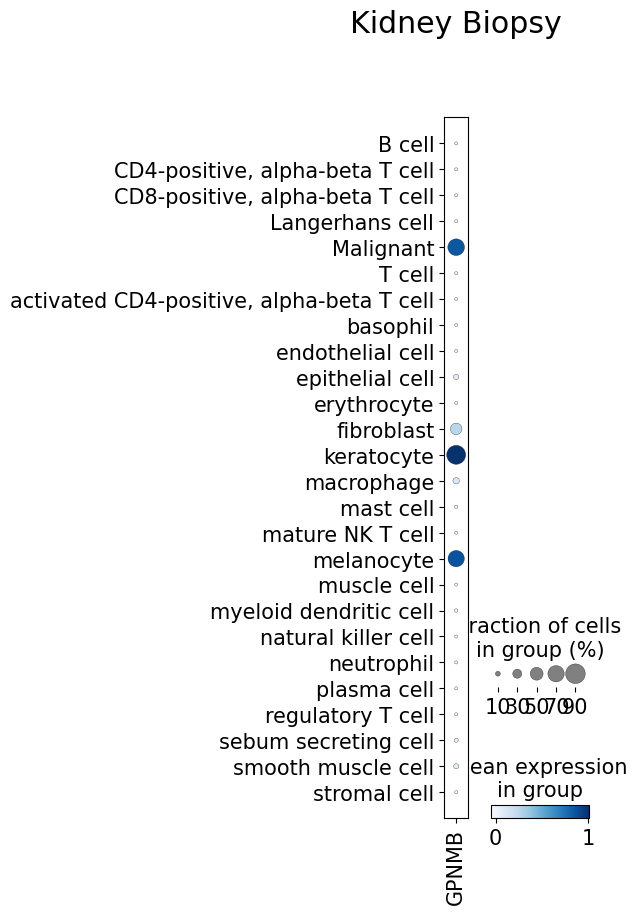

In [41]:
## Plot marker genes
plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(tmp_copy_adata, 
                  var_names=['GPNMB'], 
                  use_raw=False,
                  groupby='cell_type',
                  log=False,
                  standard_scale='var',
                  color_map='Blues',
                  vmin=-0.05,
                  vmax=1.01,
                  smallest_dot=5,
                  show=False, title='Kidney Biopsy')
    
#plt.savefig(resulthome+'Human_hearts_select_genes.pdf', bbox_inches='tight')

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

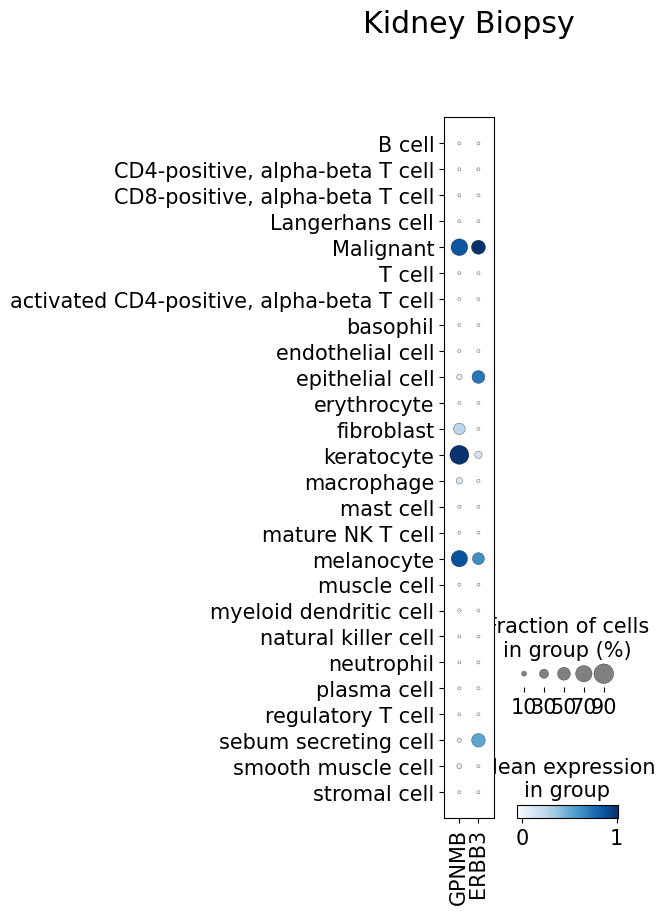

In [44]:
## Plot marker genes
plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(tmp_copy_adata, 
                  var_names=['GPNMB', 'ERBB3'], 
                  use_raw=False,
                  groupby='cell_type',
                  log=False,
                  standard_scale='var',
                  color_map='Blues',
                  vmin=-0.05,
                  vmax=1.01,
                  smallest_dot=5,
                  show=False, title='Kidney Biopsy')
    
#plt.savefig(resulthome+'Human_hearts_select_genes.pdf', bbox_inches='tight')

In [60]:
gene_list = ['GPNMB']

In [64]:
for mygene in gene_list:
    print(mygene)
    sc.tl.score_genes(tmp_copy_adata,[mygene],score_name=mygene+'_cell_score')

GPNMB


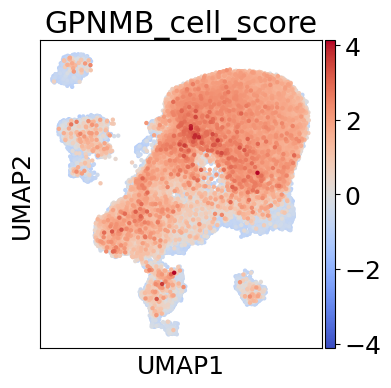

In [65]:
FIGSIZE=(4,4)
plt.rcParams['figure.figsize']=FIGSIZE

for mygene in gene_list:
    maxabs=max(abs(tmp_copy_adata.obs[mygene+'_cell_score']))
    sc.pl.umap(tmp_copy_adata,color=mygene+'_cell_score',cmap='coolwarm',s=40,vmin=-maxabs,vmax=maxabs,\
                  show=False)
    #tmp_copy_adata.obs.drop(mygene+'_cell_score',axis=1,inplace=True)
    #plt.savefig(resulthome + mygene+'_cell_score.png',bbox_inches='tight')
    plt.show()
    plt.close()

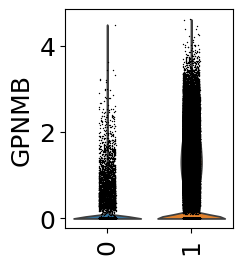

In [72]:
mytitle = 'Human MI vSMCs subtypes'

plt.rcParams.update({'font.size': 18})

# Inital setting for plot size
from matplotlib import rcParams
FIGSIZE=(3,3)
rcParams['figure.figsize']=FIGSIZE

for mygene in gene_list:
    sc.pl.violin(tmp_copy_adata,\
             keys=mygene, groupby='batch',\
             rotation=90, show=False, )
plt.savefig(resulthome + mygene + '_genes_violin.pdf', bbox_inches='tight')

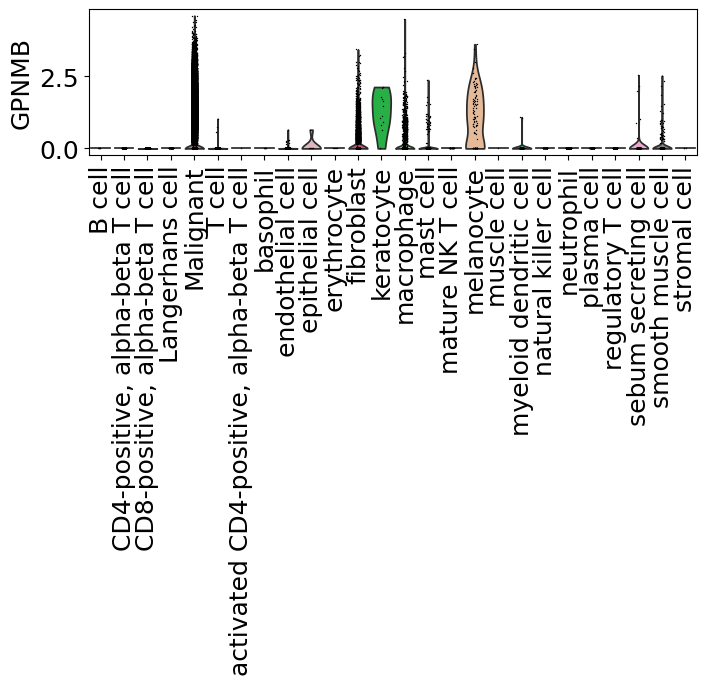

In [77]:
mytitle = 'Human MI vSMCs subtypes'

plt.rcParams.update({'font.size': 18})

# Inital setting for plot size
from matplotlib import rcParams
FIGSIZE=(7, 2)
rcParams['figure.figsize']=FIGSIZE

for mygene in gene_list:
    sc.pl.violin(tmp_copy_adata,\
             keys=mygene, groupby='cell_type',\
             rotation=90, show=False, )
plt.savefig(resulthome + mygene + '_genes_violin.pdf', bbox_inches='tight')

In [67]:
sc.tl.embedding_density(adata, basis='umap', groupby='cell_type', key_added='mydense')

In [ ]:
for batch in adata.obs["cell_type"].drop_duplicates():
    sc.pl.embedding_density(
    adata, basis='umap', key='umap_density_stage', group=batch)

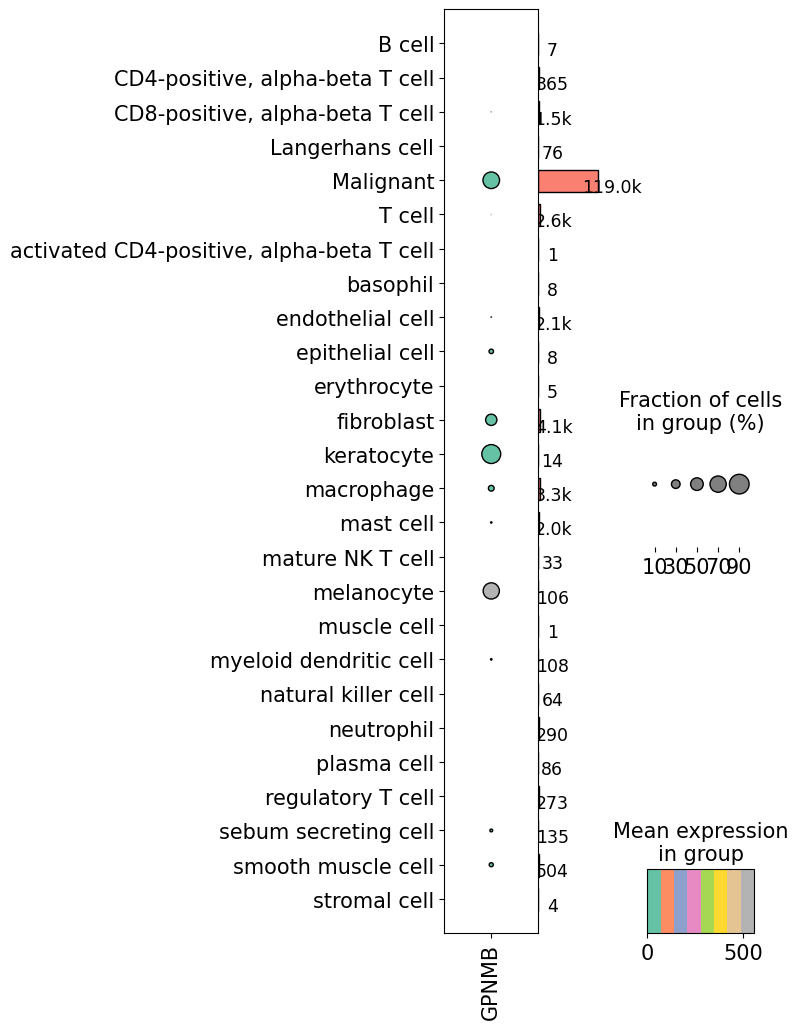

In [70]:
#fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})

dp =sc.pl.dotplot(adata, ['GPNMB'], groupby="cell_type", dendrogram=False,\
                  figsize=(4, 12), return_fig=True)

dp.add_totals().style(dot_edge_color='black', dot_edge_lw=1., cmap="Set2").show()

#dp.savefig(resulthome+'Human_hearts_select_genes_dots.pdf', bbox_inches='tight')

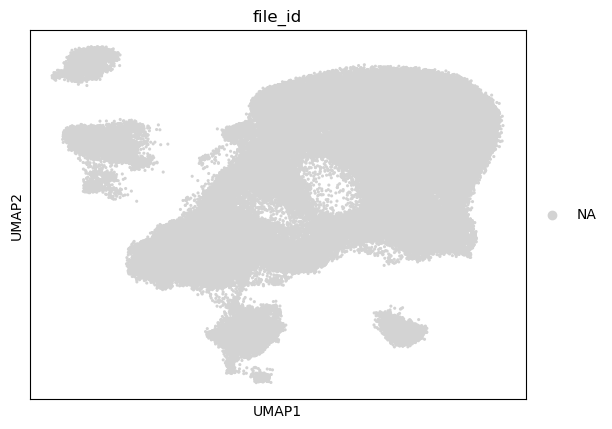

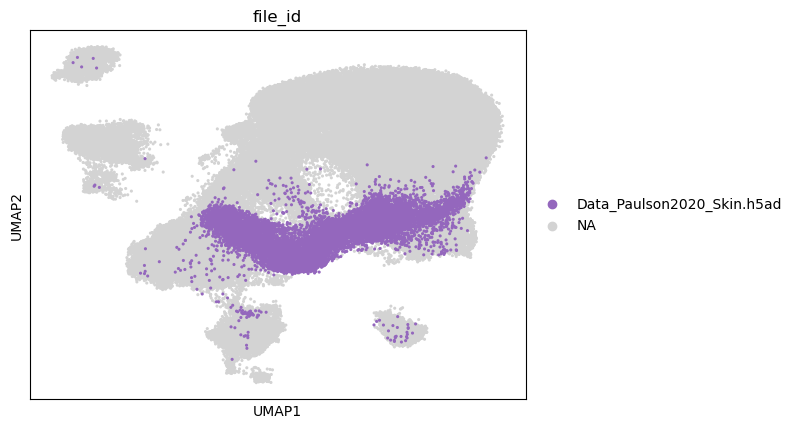

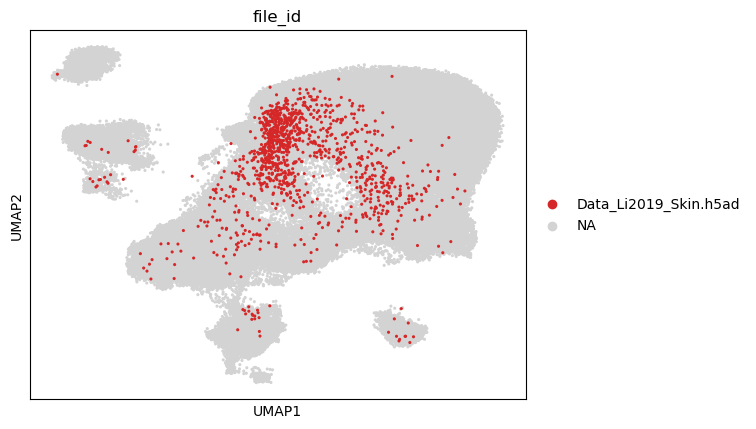

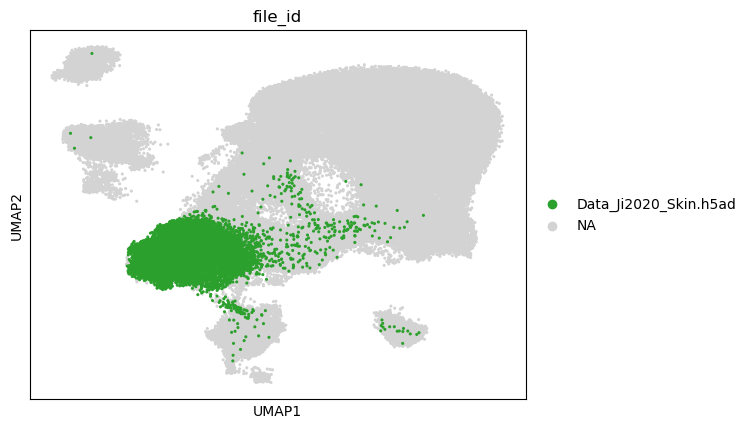

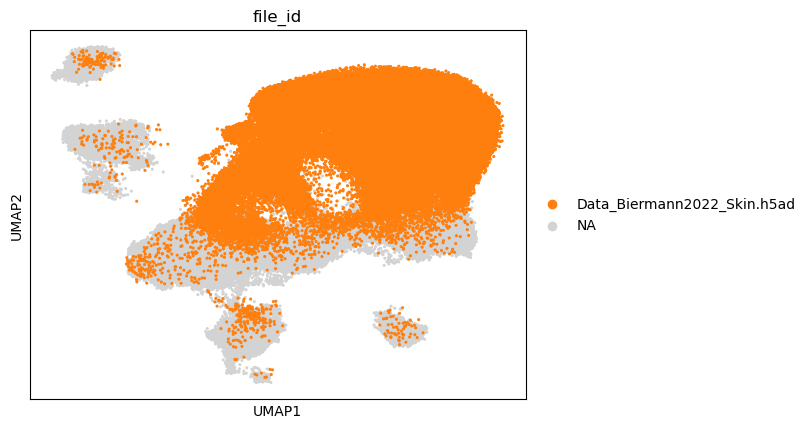

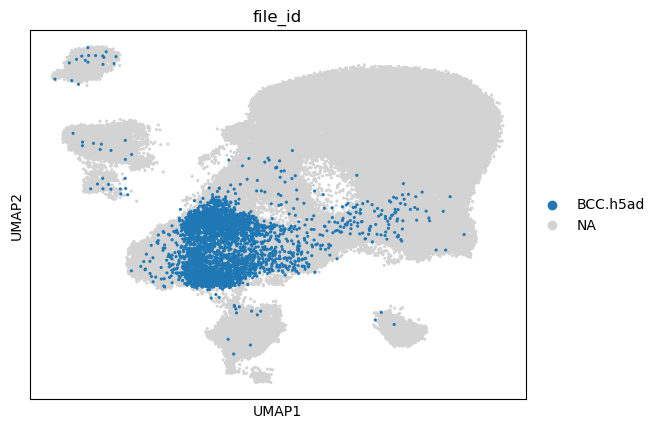

In [23]:
for batch in adata.obs["file_id"].drop_duplicates():
    sc.pl.umap(adata, color='file_id', groups=[batch], size=20)

/tmp/ipykernel_2964341/1175308326.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_counter_df = hdata.obs.reset_index()[["index", myid]].groupby(myid).count().reset_index()


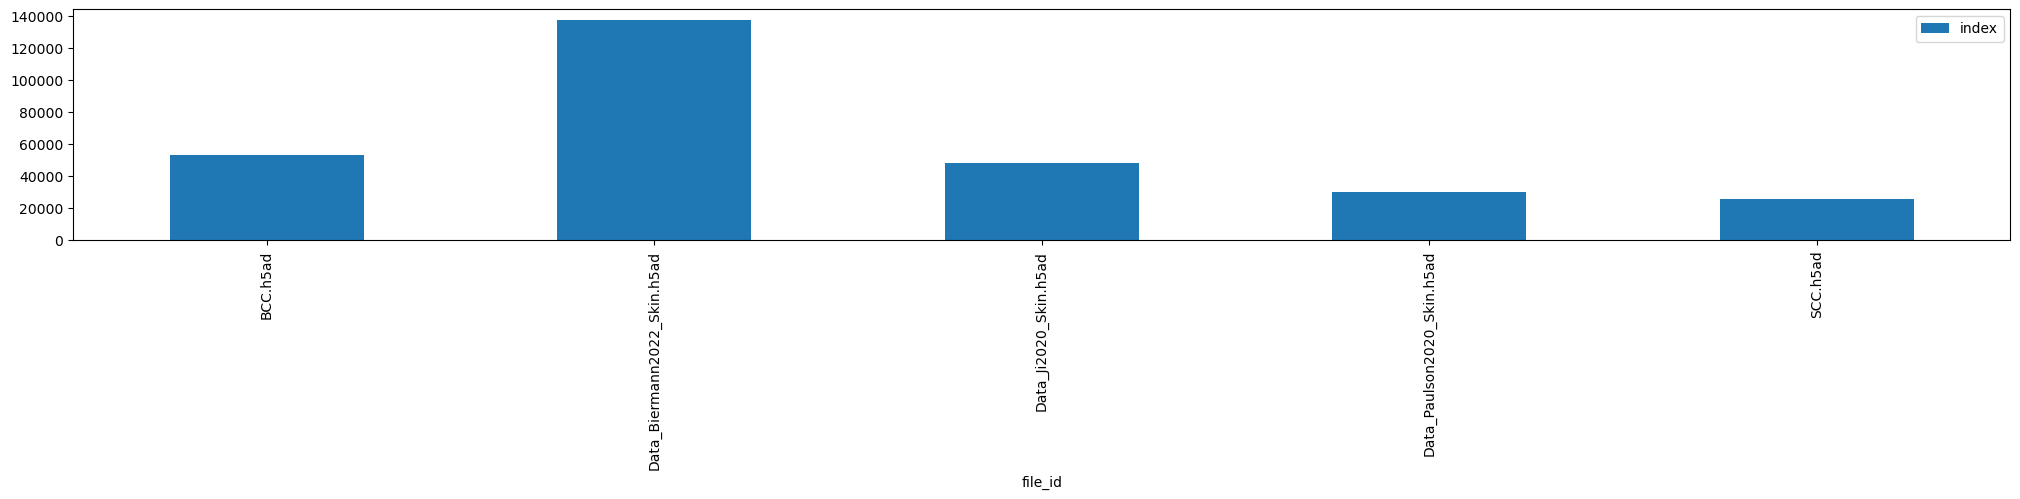

In [71]:
myid = "file_id"
temp_counter_df = hdata.obs.reset_index()[["index", myid]].groupby(myid).count().reset_index()

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (25, 3)}):
    ax = temp_counter_df.plot.bar(x=myid, y="index", rot=90)
    plt.savefig(resulthome+'skin_'+myid+'_qc_counts.png', bbox_inches='tight')

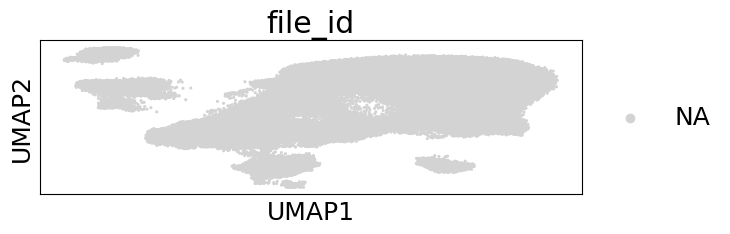

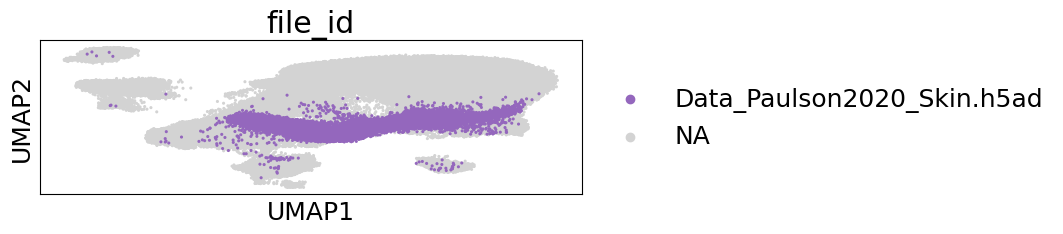

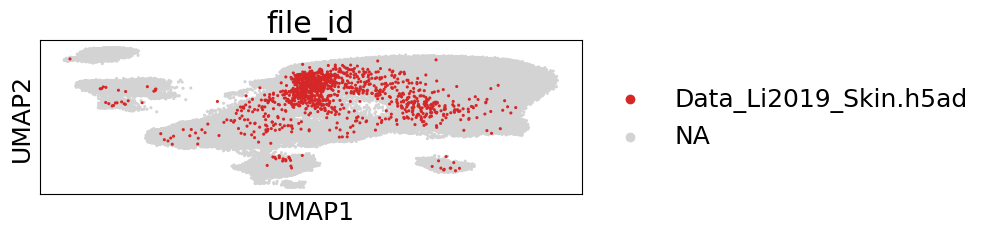

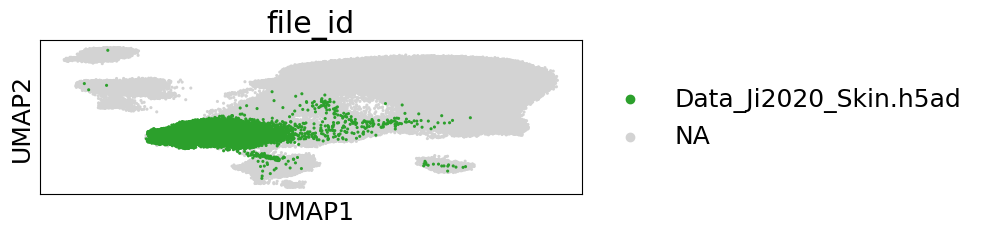

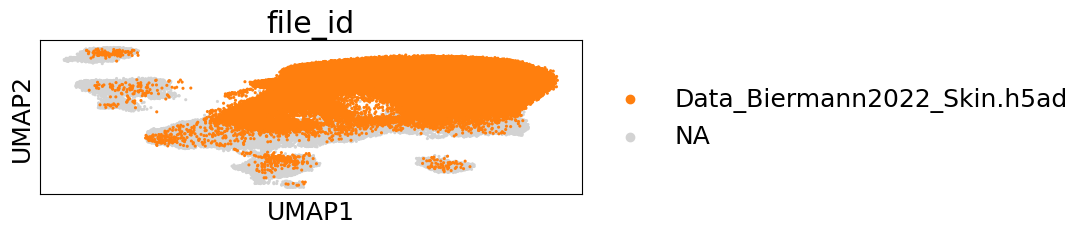

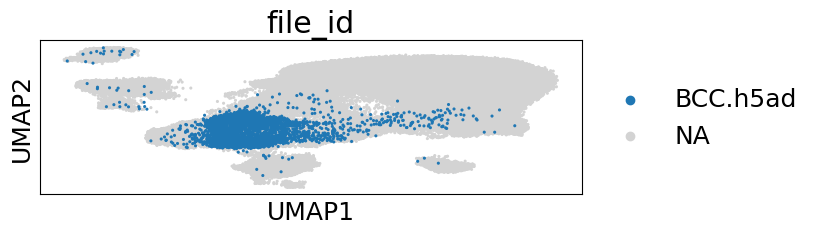

In [78]:
for batch in adata.obs["file_id"].drop_duplicates():
    sc.pl.umap(adata, color='file_id', groups=[batch], size=20)

In [79]:
## check malignant cell overlap from the cancer datasets

In [74]:
Counter(hdata.obs['cell_type'])

Counter({'Malignant': 117798,
         'T_cell': 64018,
         'Myeloid': 18842,
         'Epithelial': 18508,
         'T_NK_cell': 18259,
         nan: 10112,
         'Macrophage': 9736,
         'B_cell': 8107,
         'Dendritic': 7825,
         'Fibroblast': 5130,
         'Plasma': 4690,
         'Langerhans': 3802,
         'NK_cell': 2194,
         'Endothelial': 1819,
         'Melanocyte': 1002,
         'Neuron': 792,
         'Oligodendrocyte': 685,
         'Pericyte': 540,
         'Astrocyte': 231})

In [75]:
Counter(hdata.obs['cell_subtype'])

Counter({'Tumor cells': 91525,
         nan: 78072,
         'CD8_mem_T_cell': 17343,
         'MDM': 10865,
         'CD8_ex_T_cell': 7885,
         'CD4_T_cell': 7765,
         'Treg': 7627,
         'B_cell_1': 5829,
         'CD8+ T cells TOX+': 5474,
         'CD8_act_T_cell': 5470,
         'CD8+ T cells TCF7+': 3675,
         'CD4+ T cells': 3657,
         'CD8_naive_T_cell': 3159,
         'Macrophage': 3093,
         'Tfh': 3085,
         'CAFs': 2804,
         'Plasma': 2646,
         'Naive_T_cell': 2501,
         'Malignant_1': 2462,
         'Tregs': 2284,
         'MDM FTL+': 2184,
         'Monocytes': 2119,
         'Plasma cells': 1977,
         'Th17': 1783,
         'Microglia': 1658,
         'Cycling cells': 1338,
         'Tfh-like cells': 1300,
         'Malignant_2': 1089,
         'CAF': 1066,
         'NK_cell': 1041,
         'Activated B cells': 1032,
         'CD8_eff_T_cell': 1032,
         'pDC': 979,
         'Endothelial cells': 896,
         'T_cell_pr

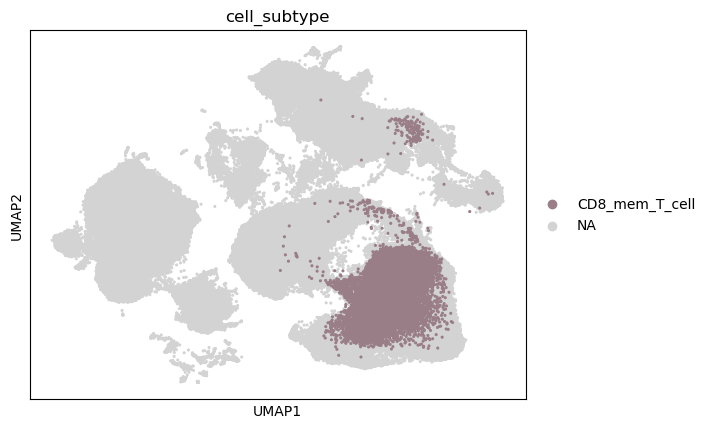

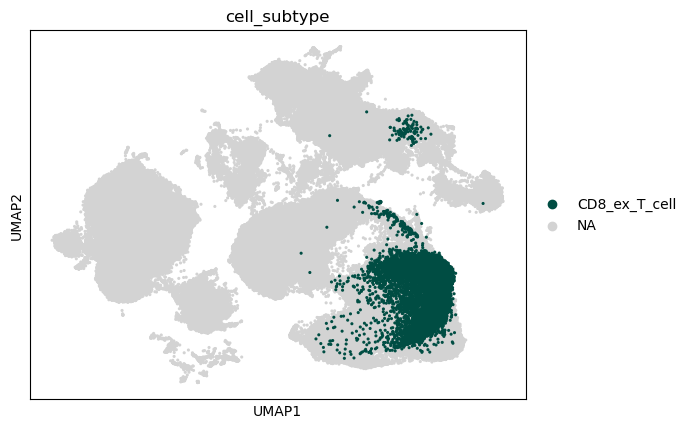

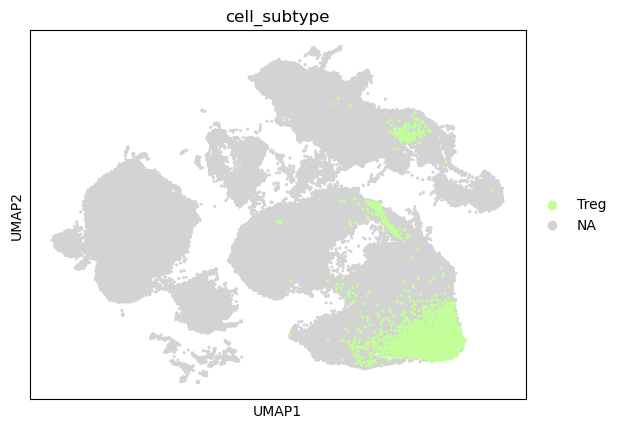

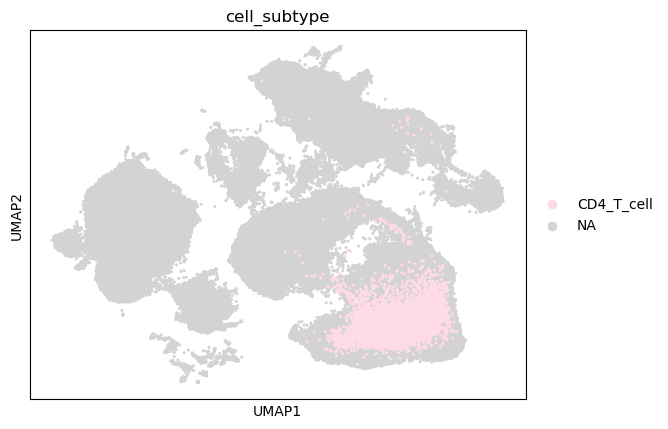

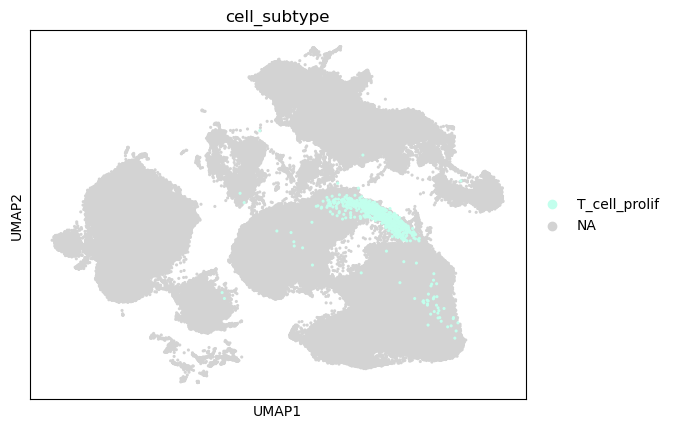

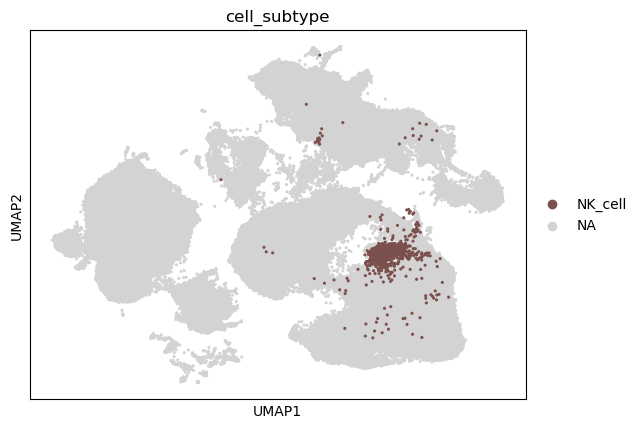

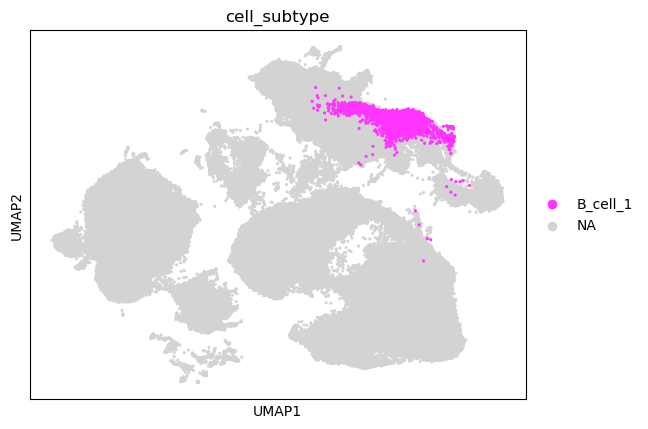

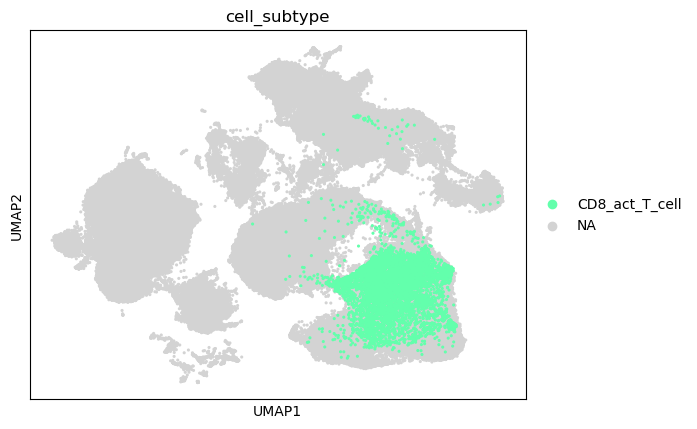

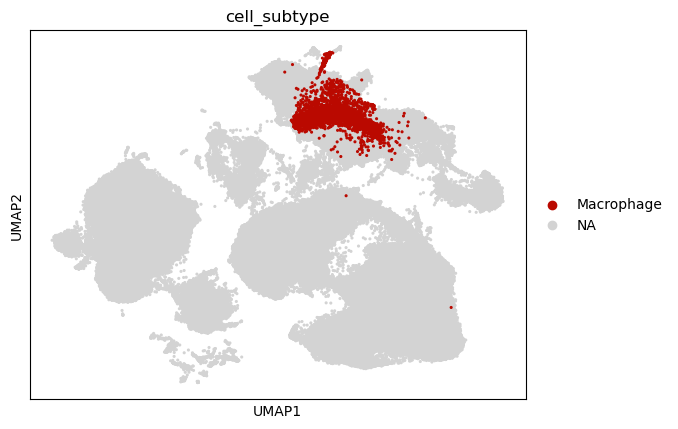

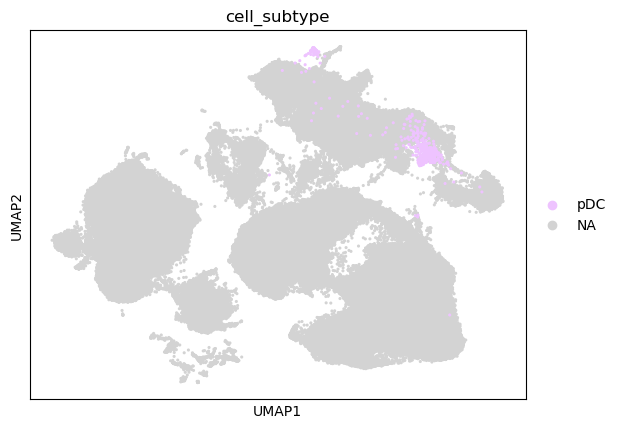

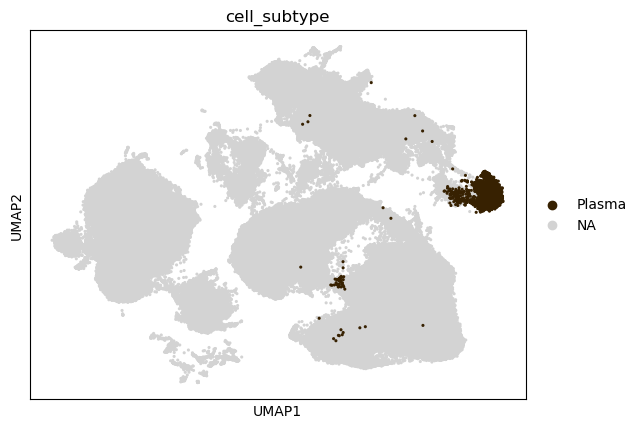

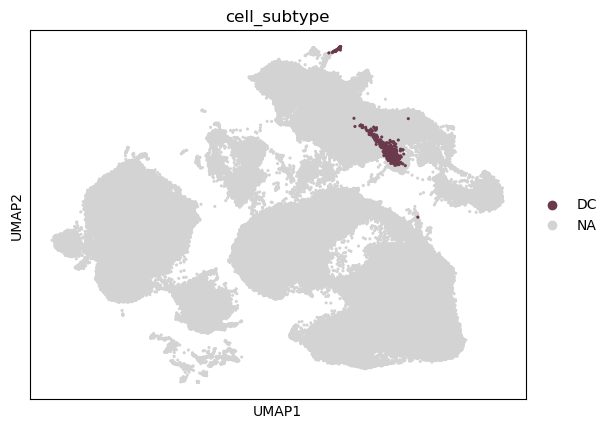

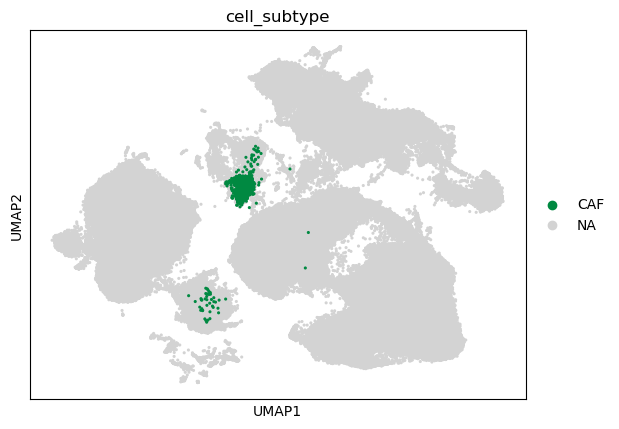

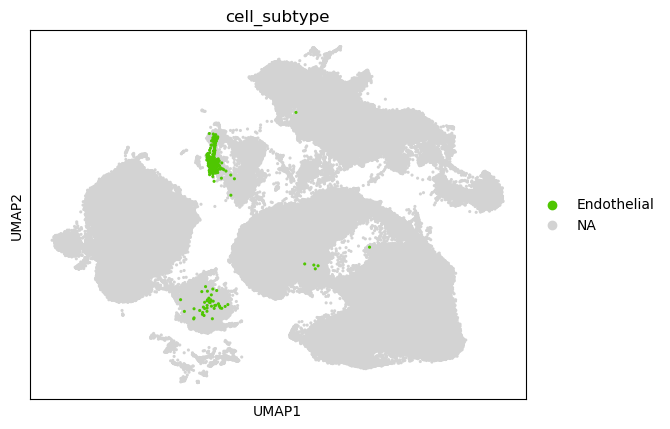

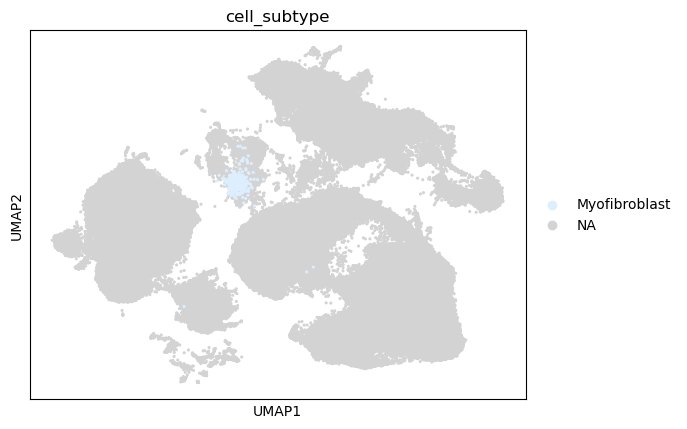

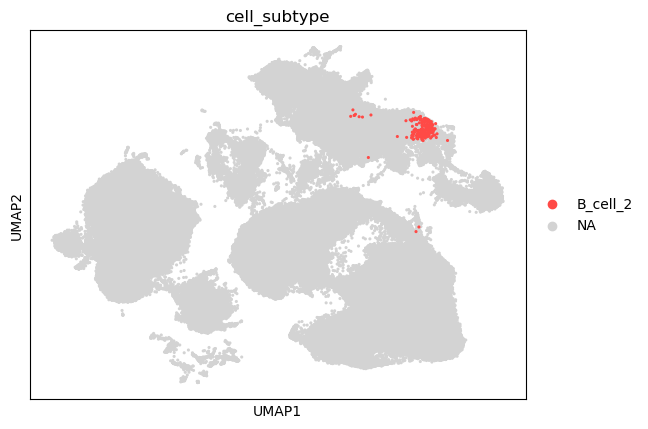

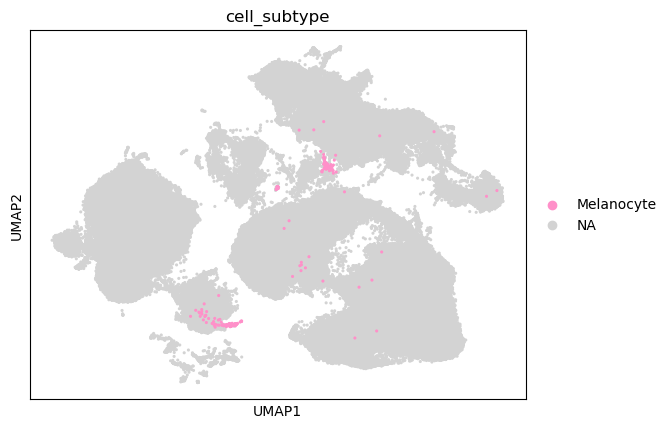

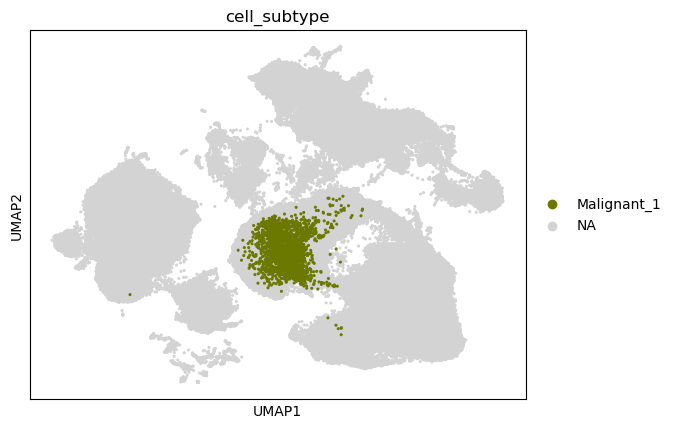

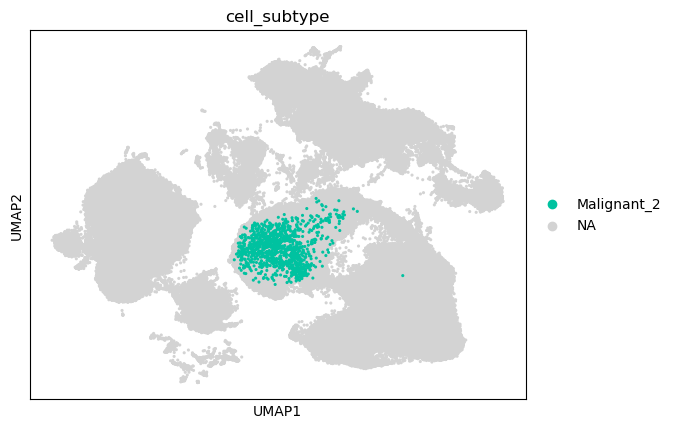

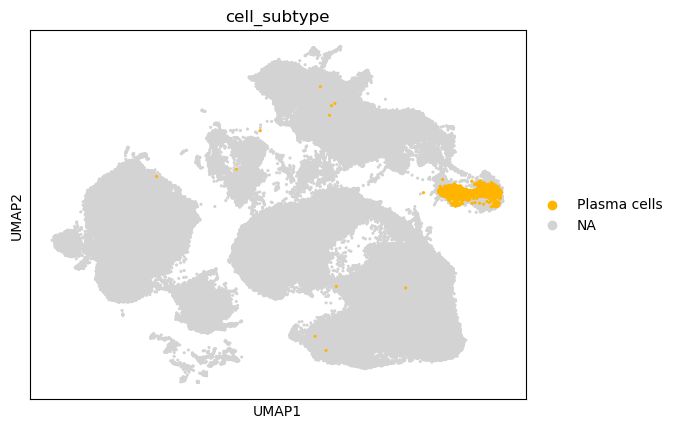

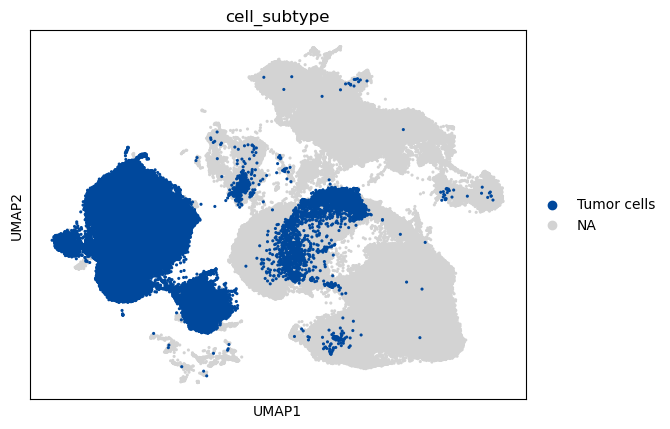

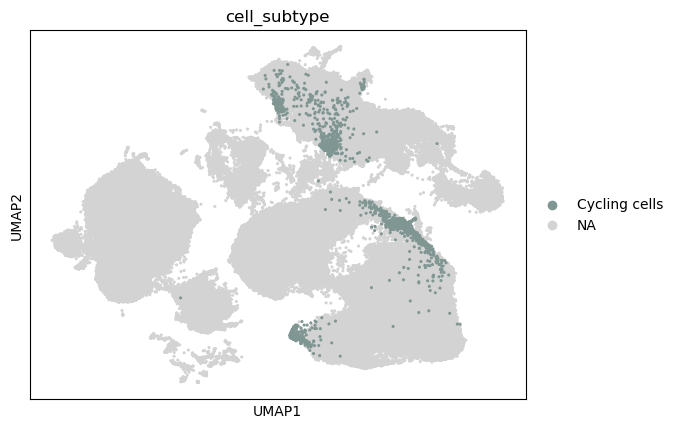

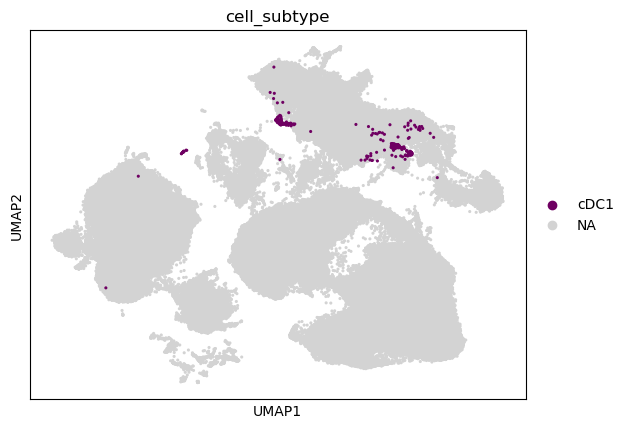

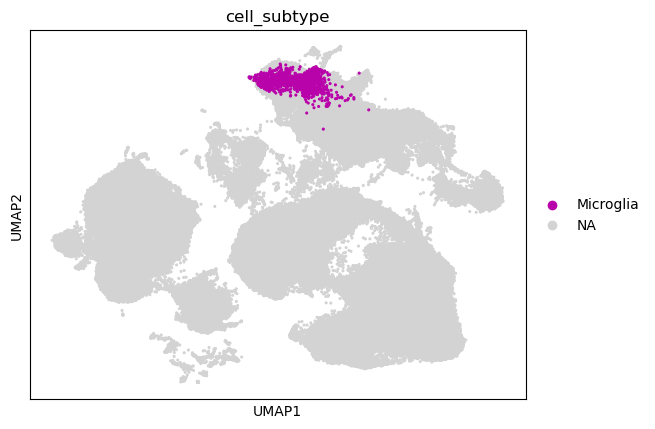

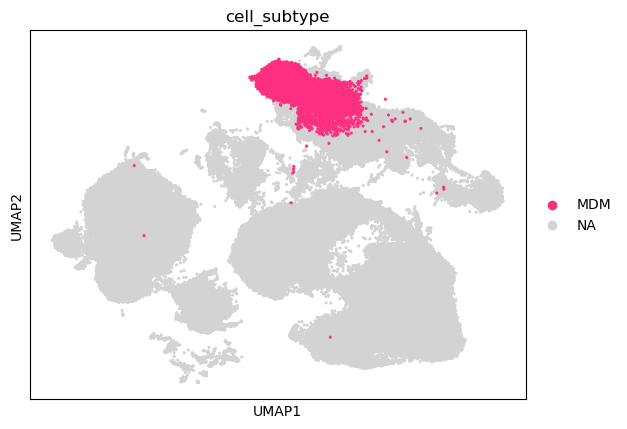

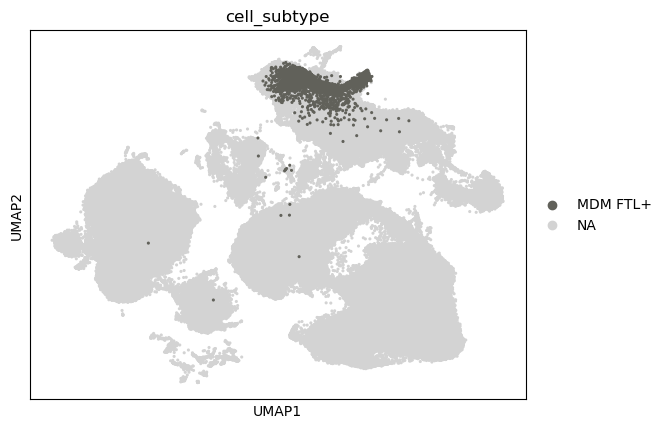

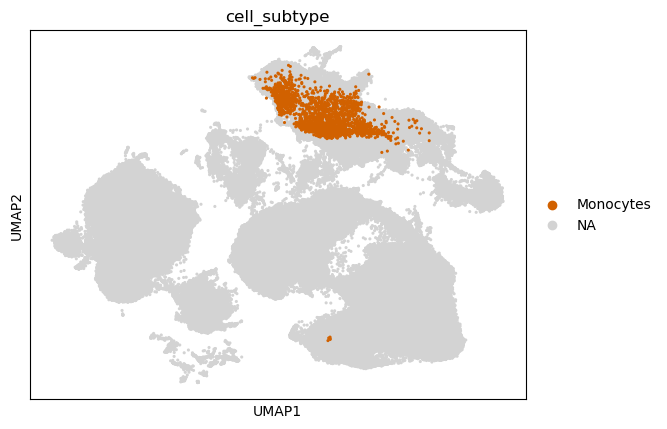

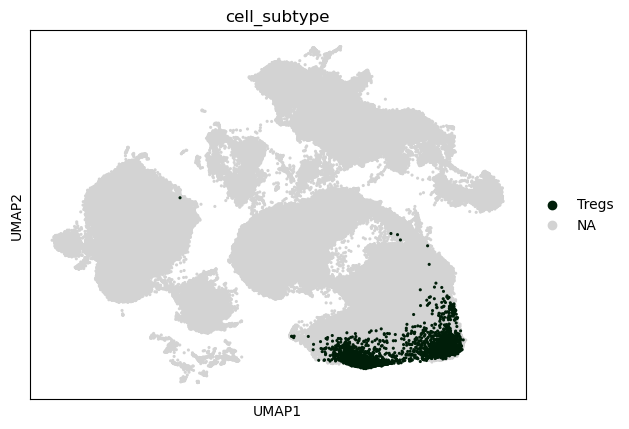

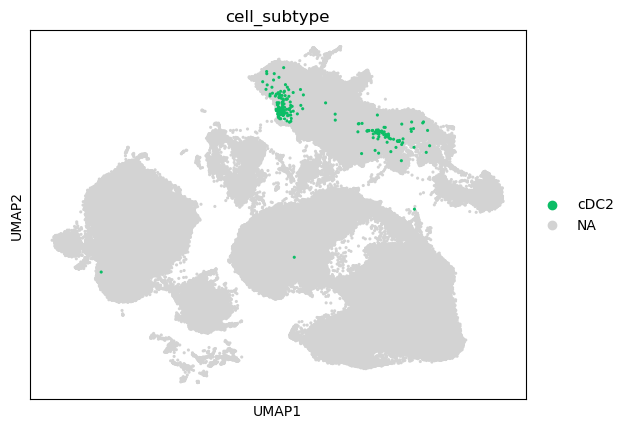

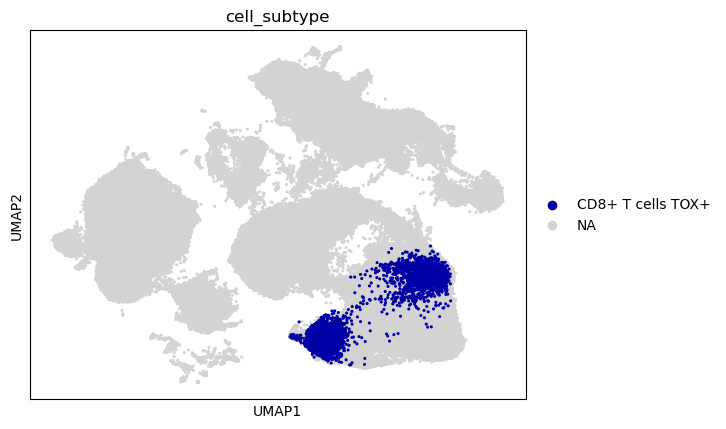

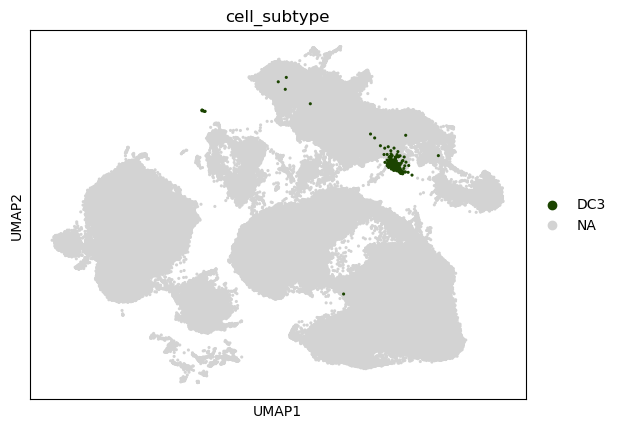

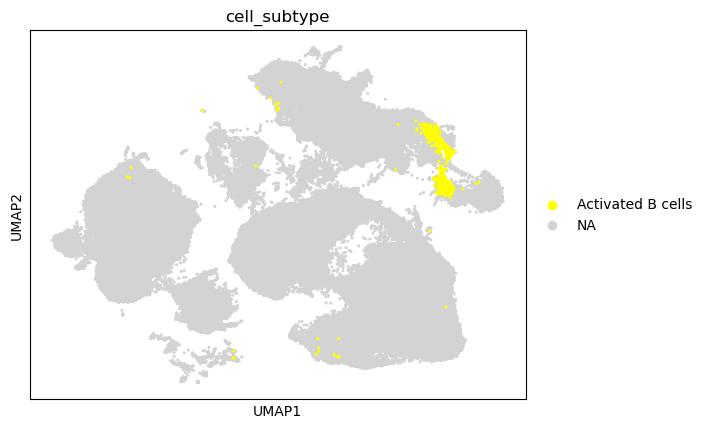

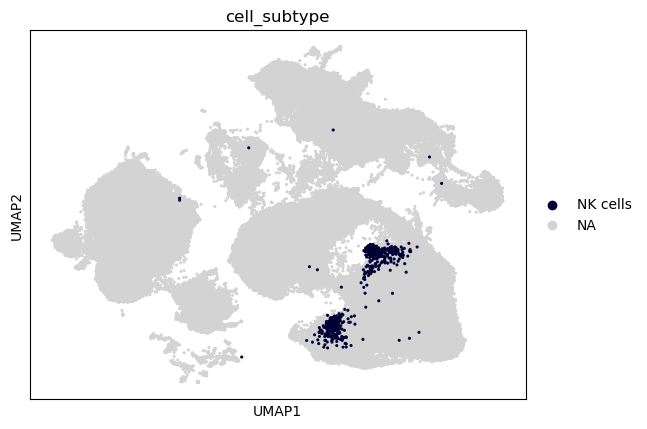

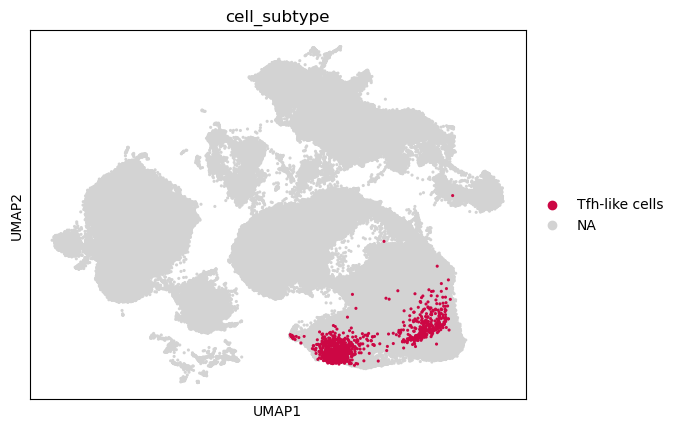

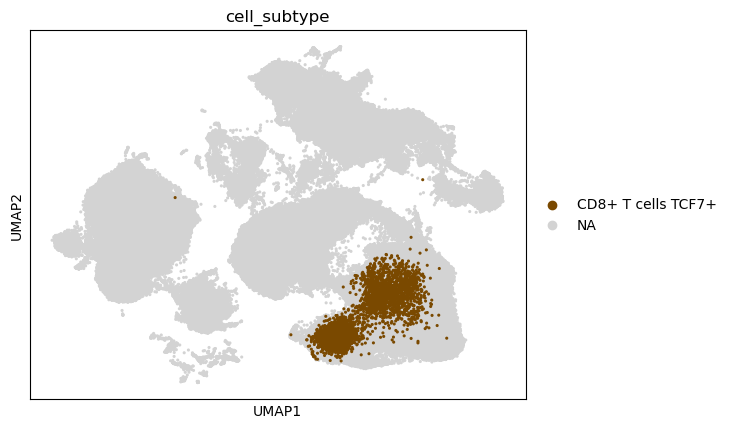

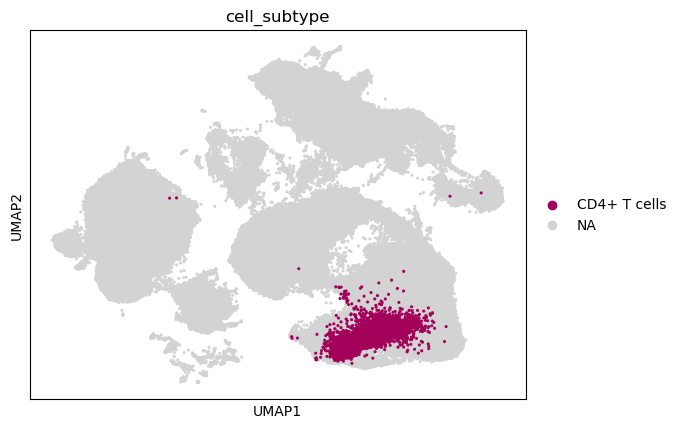

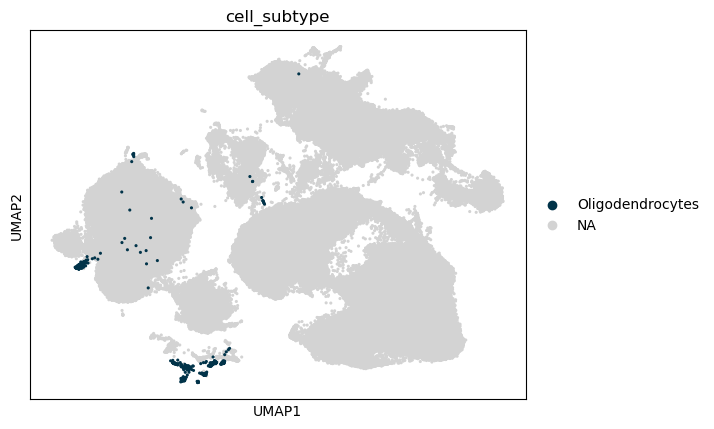

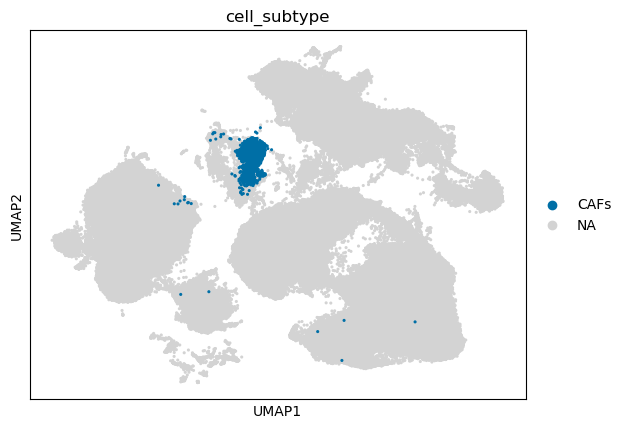

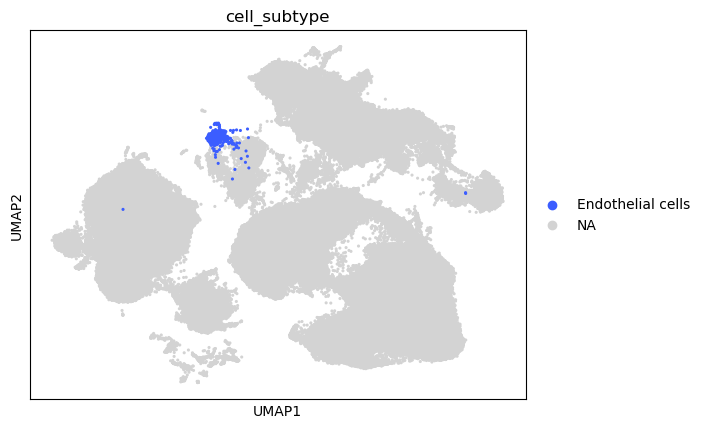

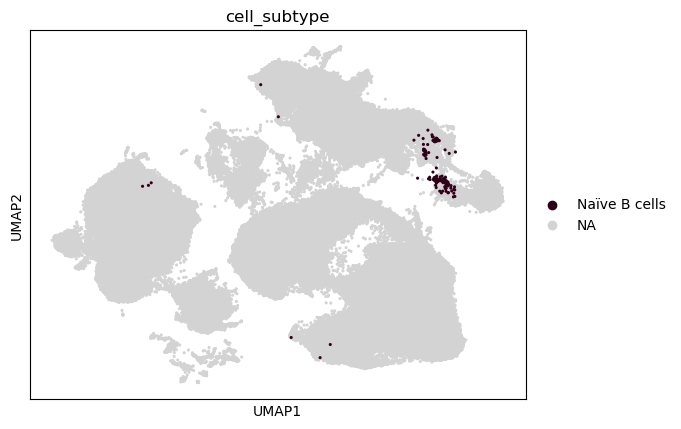

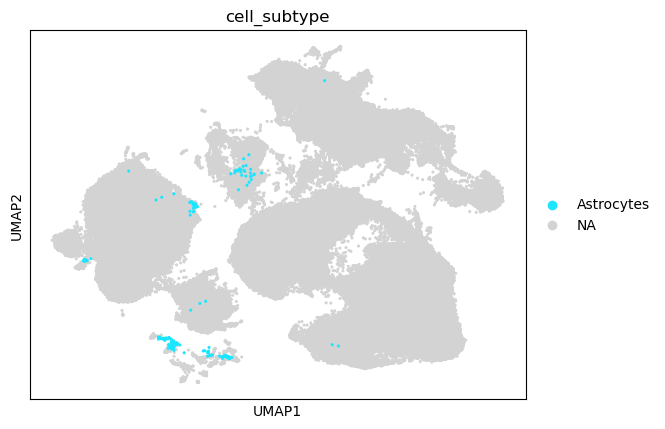

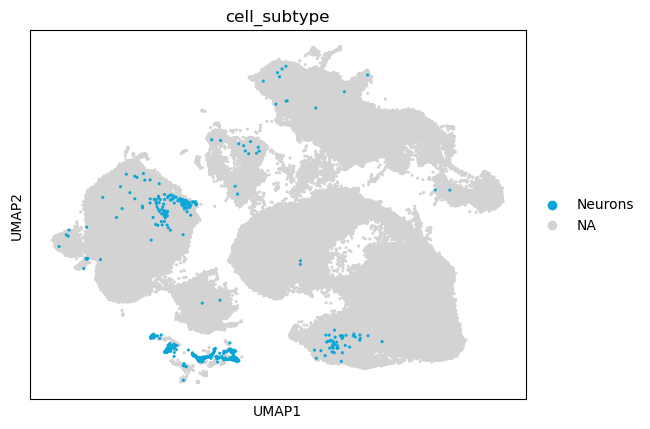

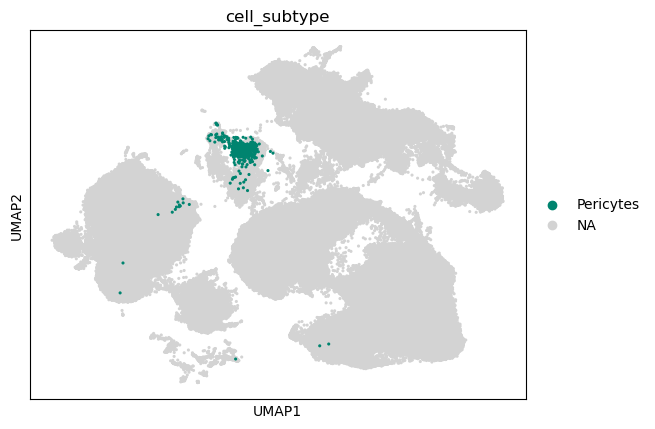

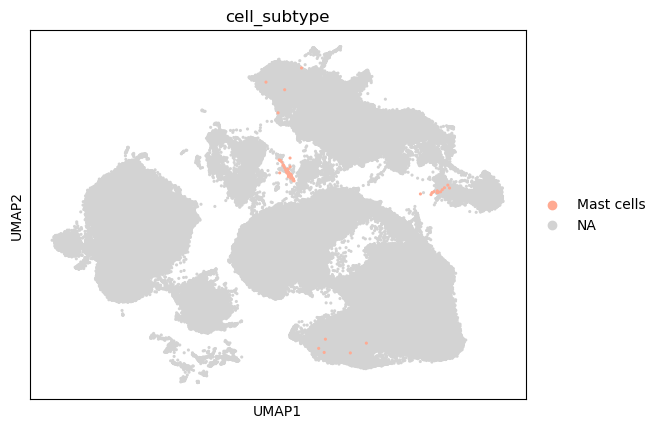

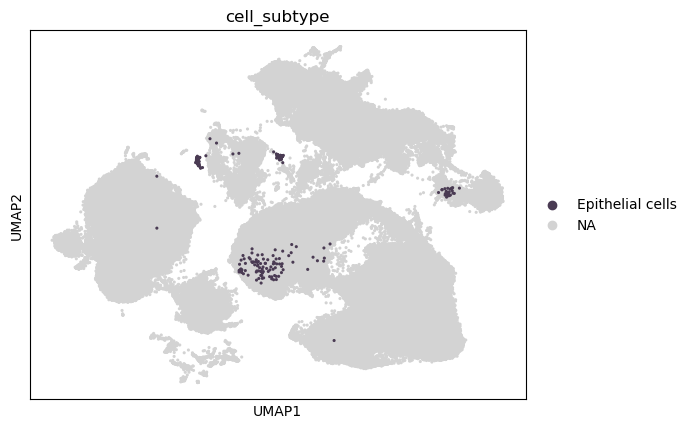

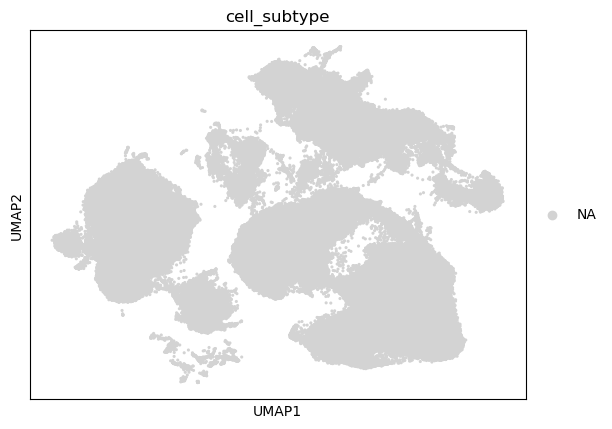

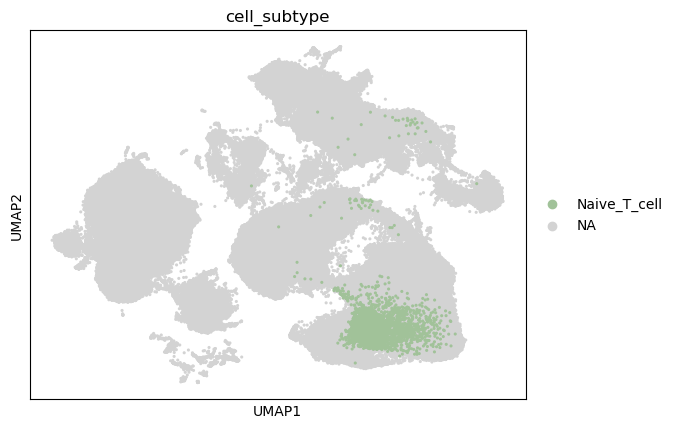

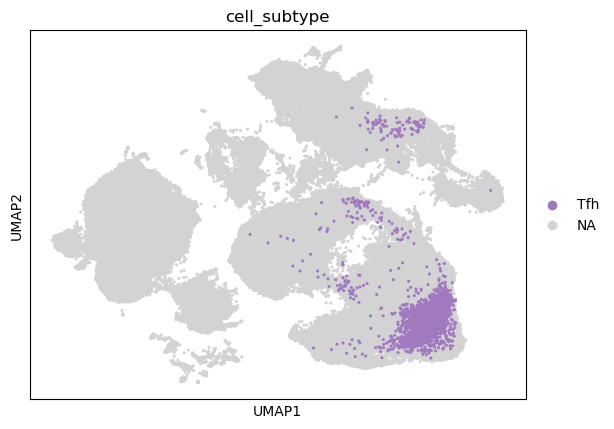

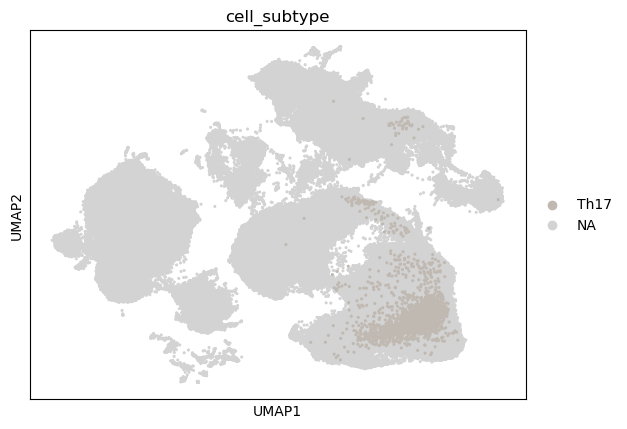

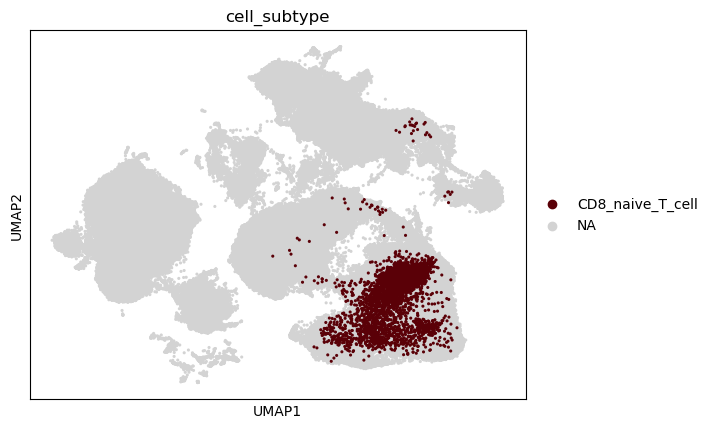

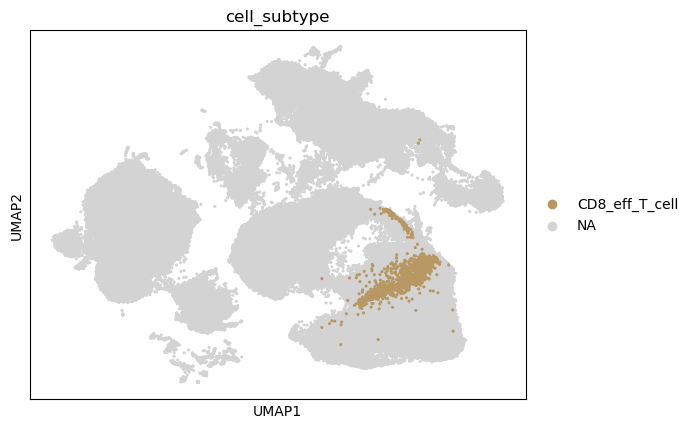

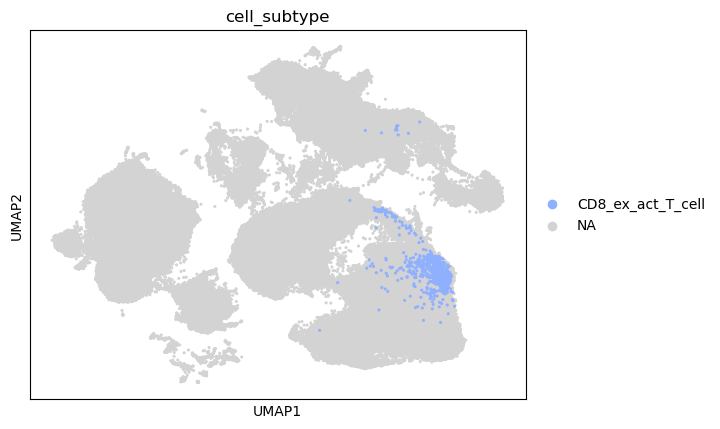

In [77]:
for batch in bdata.obs["cell_subtype"].drop_duplicates():
    sc.pl.umap(bdata, color='cell_subtype', groups=[batch], size=20)

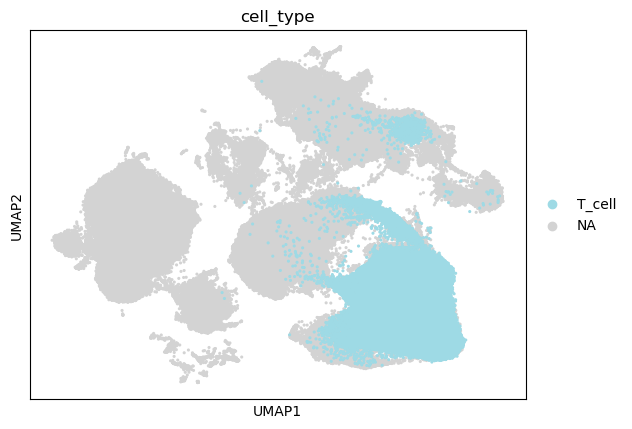

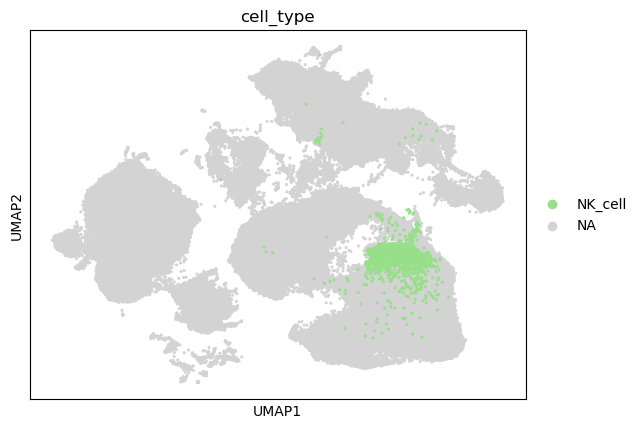

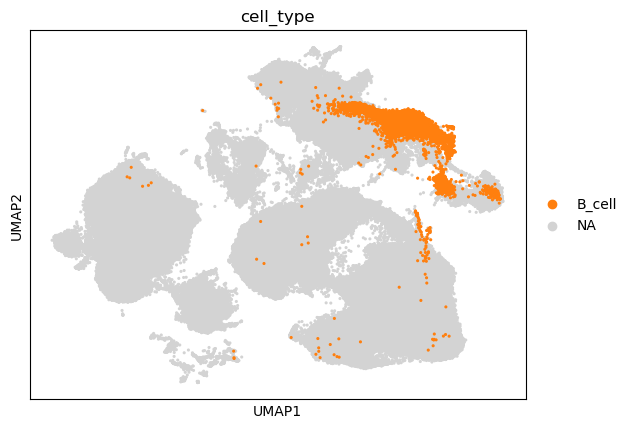

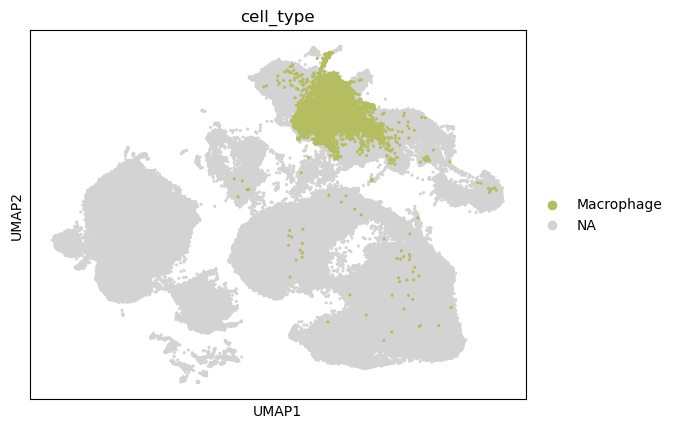

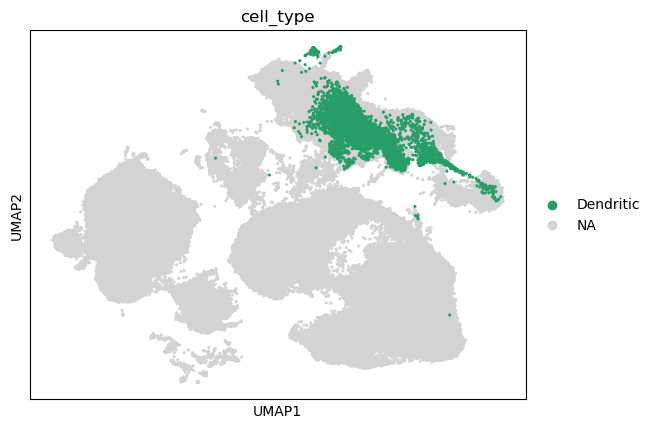

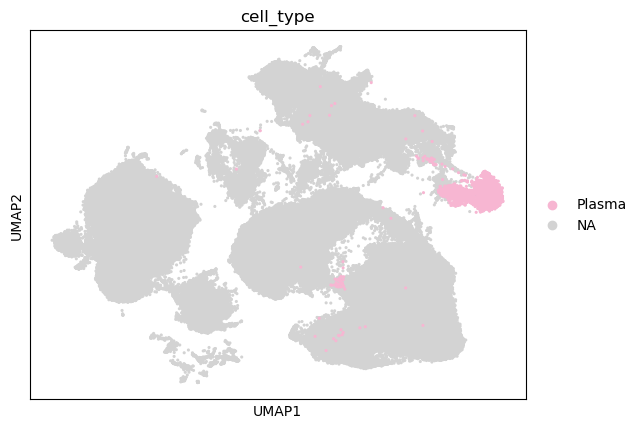

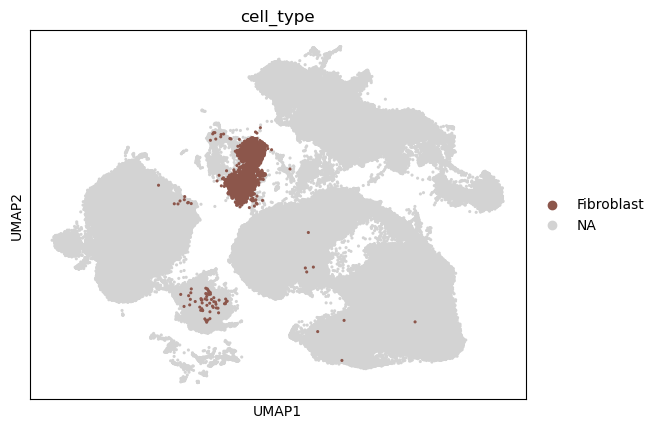

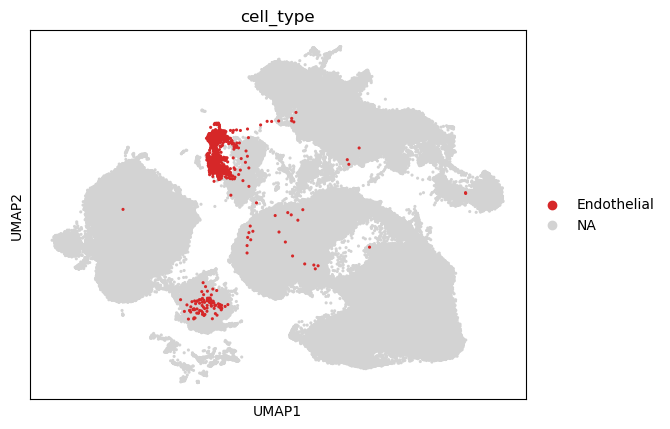

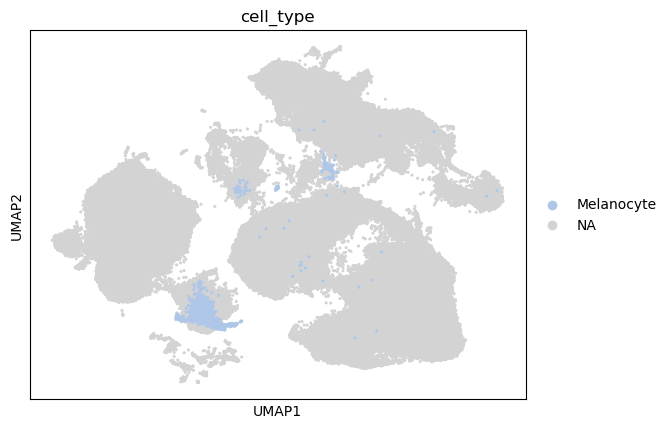

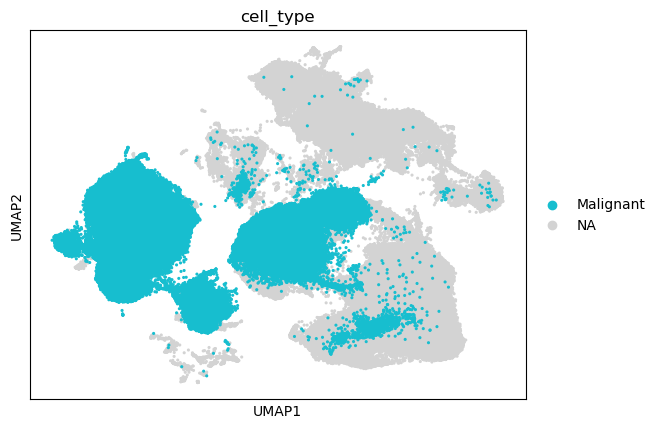

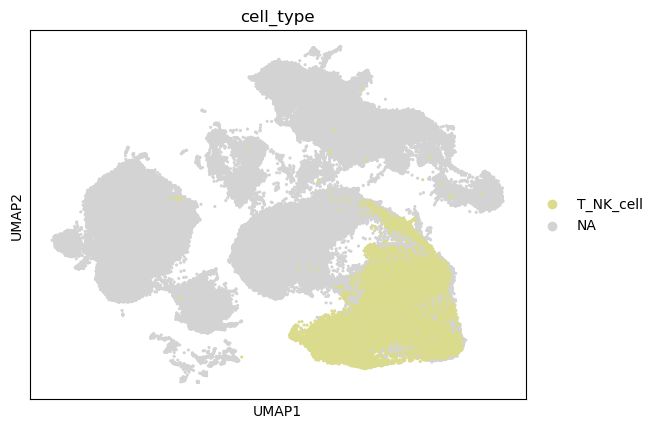

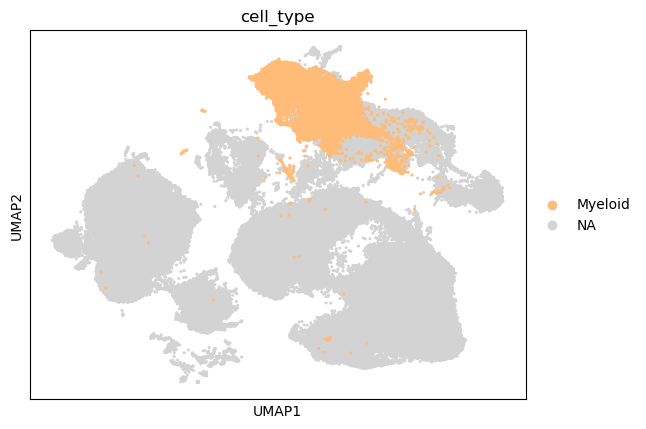

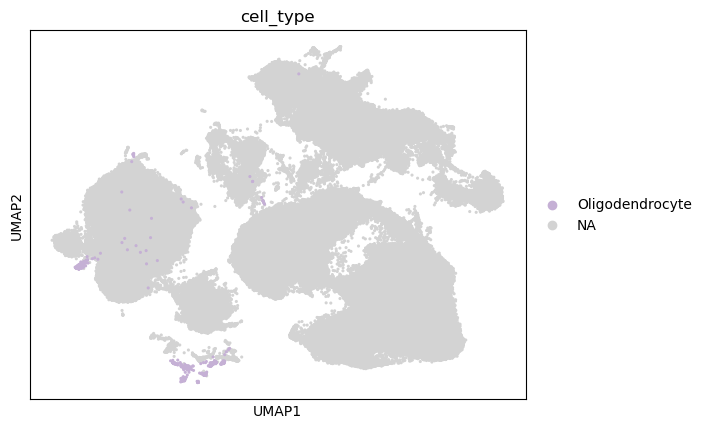

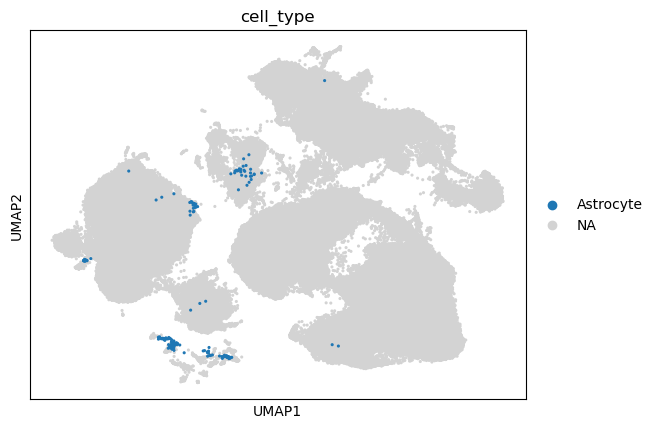

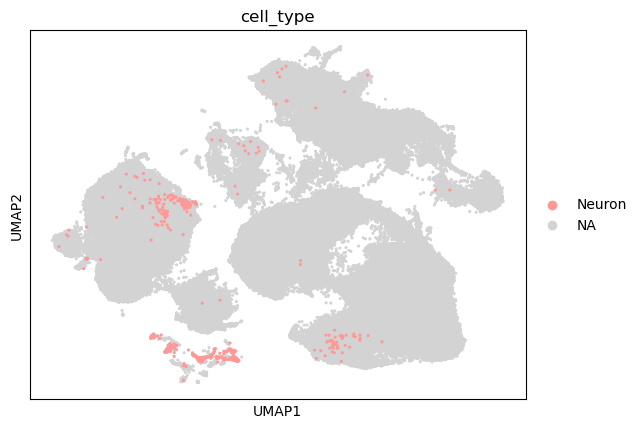

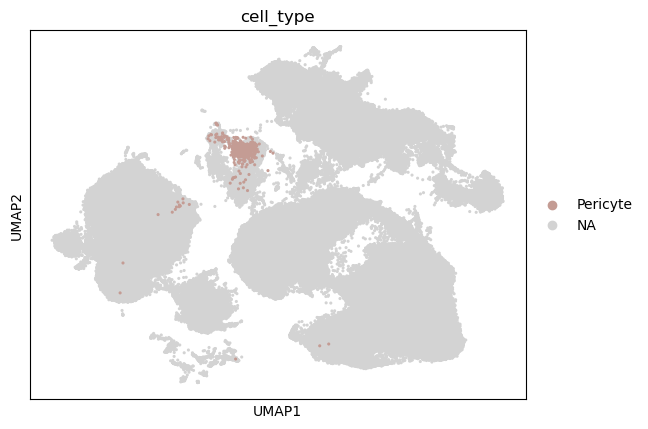

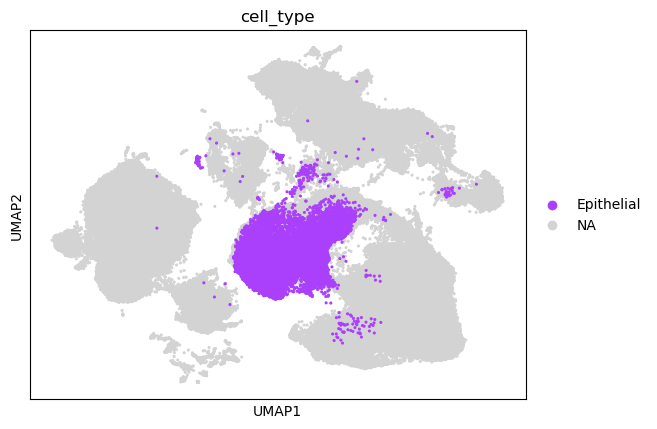

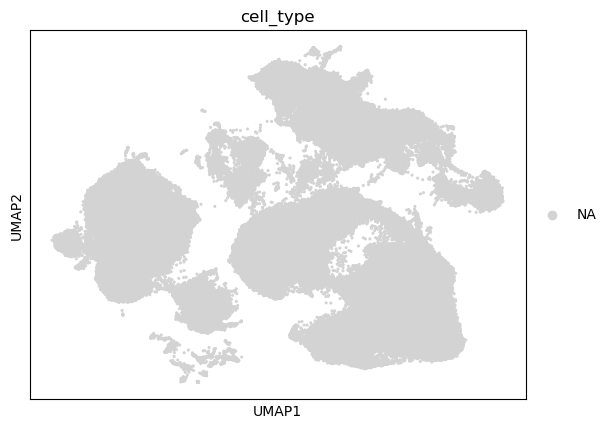

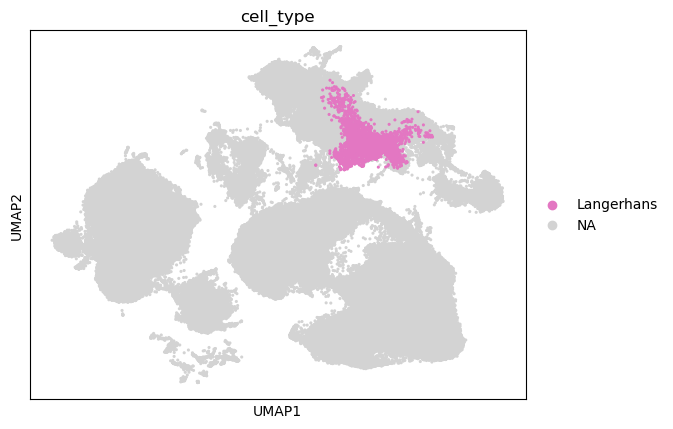

In [78]:
for batch in bdata.obs["cell_type"].drop_duplicates():
    sc.pl.umap(bdata, color='cell_type', groups=[batch], size=20)

In [79]:
bdata

AnnData object with n_obs × n_vars = 294090 × 12154
    obs: 'cell_name', 'sample', 'patient', 'cell_type', 'cell_subtype', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'disease', 'time_point', 'treatment', 'source', 'sort', 'n_genes', 'file_id', 'cell_subtype_level1', 'cell_subtype_level2', 'timepoint', 'batch', 'leiden0.1', 'leiden0.2', 'leiden0.3', 'leiden0.4', 'leiden0.5'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'PC_harmony', 'umap', 'leiden0.1', 'leiden0.2', 'leiden0.3', 'leiden0.4', 'leiden0.5', 'leiden0.5_colors', 'file_id_colors', 'cell_subtype_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    obsp: 'PC_harmony_distances', 'PC_harmony_connectivities'

In [83]:
bdata.obs[['cell_type', 'cell_subtype', 'treatment']]

cell_type    cell_subtype      treatment
0-0        T_cell  CD8_mem_T_cell  Pembrolizumab
1-0        T_cell   CD8_ex_T_cell  Pembrolizumab
2-0        T_cell  CD8_mem_T_cell  Pembrolizumab
3-0        T_cell  CD8_mem_T_cell  Pembrolizumab
4-0        T_cell            Treg  Pembrolizumab
...           ...             ...            ...
26011-4    T_cell            Th17            NaN
26012-4    T_cell            Th17            NaN
26013-4    T_cell  CD8_eff_T_cell            NaN
26014-4    T_cell            Treg            NaN
26015-4    T_cell  CD8_eff_T_cell            NaN

[294090 rows x 3 columns]

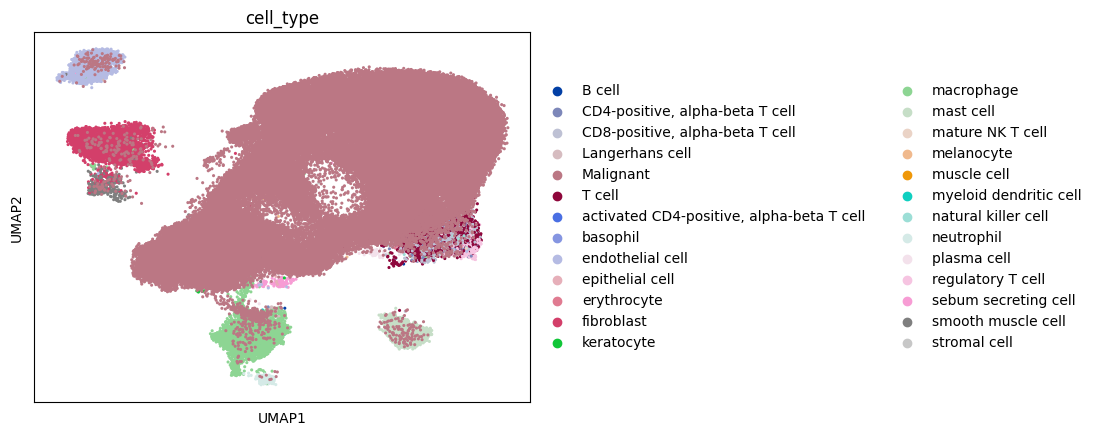

In [10]:
sc.pl.umap(adata, color=["cell_type"], size=20)

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data
mal_ts = sc.read_h5ad("/data/Kramann_lab/From_Leon/3CA_anndatas/human_skin_ts_after_batcheffect_corrected.h5ad")
skin   = sc.read_h5ad("/data/Kramann_lab/From_Leon/3CA_anndatas/skin/skin_all_after_subclustering_spp1.h5ad")
tdata  = sc.read_h5ad("/data/Kramann_lab/From_Leon/tabula_sapiens/skin_ts_human.h5ad")

# 2. Replace 'nan' with 'Malignant' in mal_ts broad_cell_class
mal_ts.obs['broad_cell_class'] = mal_ts.obs['broad_cell_class'].astype(str).replace('nan', 'Malignant')

In [52]:
# 3. Normalize cell type names (lowercase, stripped)
def norm_names(series):
    return series.astype(str).str.lower().str.strip()

skin.obs['broad_cell_class_norm']   = norm_names(skin.obs['cell_type'])
mal_ts.obs['broad_cell_class_norm'] = norm_names(mal_ts.obs['broad_cell_class'])
tdata.obs['broad_cell_class_norm']  = norm_names(tdata.obs['broad_cell_class'])

# 4. Build color map with red for malignant
all_types = (
    list(skin.obs['broad_cell_class_norm'].unique()) +
    list(mal_ts.obs['broad_cell_class_norm'].unique()) +
    list(tdata.obs['broad_cell_class_norm'].unique())
)
all_types_unique = pd.Series(all_types).unique()

# Assign colors (malignant is red, rest from palette)
base_palette = sns.color_palette("tab20", len(all_types_unique))
color_map = {}
for ct, col in zip(all_types_unique, base_palette):
    if ct == 'malignant':  # Always lowercase due to normalization!
        color_map[ct] = (1.0, 0.0, 0.0) # red (RGB)
    else:
        color_map[ct] = col

# 5. Lighter shades for tdata
from matplotlib.colors import to_rgb
def lighten_color(color, amount=0.4):
    c = np.array(to_rgb(color))
    white = np.array([1, 1, 1])
    return tuple(c + (white - c) * amount)

tdata_color_map = {ct: lighten_color(color_map[ct], amount=0.4) for ct in tdata.obs['broad_cell_class_norm'].unique() if ct in color_map}

# 6. mal_ts color map (malignant is red, others from tdata lighter map)
mal_ts_color_dict = {}
for ct in mal_ts.obs['broad_cell_class_norm'].unique():
    if ct == 'malignant':
        mal_ts_color_dict[ct] = (1.0, 0.0, 0.0)
    elif ct in tdata_color_map:
        mal_ts_color_dict[ct] = tdata_color_map[ct]
    else:
        mal_ts_color_dict[ct] = (0.5, 0.5, 0.5)

# 7. Plotting function with larger figures, no legend, and correct groupby
def plot_umap_with_labels(adata, groupby, color_dict, title, figsize=(10,8), bring_to_front='malignant'):
    import matplotlib.patheffects as PathEffects
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Case-insensitive matching
    bring_to_front = bring_to_front.lower()
    # Get all categories, and move 'malignant' to the end if present
    unique_types = pd.Series(adata.obs[groupby].unique())
    unique_types_lower = unique_types.str.lower()
    if bring_to_front in unique_types_lower.values:
        # Remove 'malignant' from list and append it to the end
        idx = unique_types_lower[unique_types_lower == bring_to_front].index[0]
        categories = list(unique_types.drop(idx)) + [unique_types[idx]]
    else:
        categories = list(unique_types)

    # Make groupby column categorical with desired order
    adata.obs[groupby] = pd.Categorical(adata.obs[groupby], categories=categories, ordered=True)

    # Build palette in same order
    palette = [color_dict.get(ct, (0.5,0.5,0.5)) for ct in categories]

    plt.figure(figsize=figsize)
    sc.pl.umap(
        adata, 
        color=groupby,
        palette=palette,
        show=False,
        legend_loc='none',
        size=20
    )

    ax = plt.gca()
    for ct in categories:
        mask = adata.obs[groupby] == ct
        if np.sum(mask) == 0:
            continue
        x = np.median(adata.obsm['X_umap'][mask, 0])
        y = np.median(adata.obsm['X_umap'][mask, 1])
        txt = ax.text(
            x, y, ct, fontsize=12, weight='bold',
            color=color_dict.get(ct, "black"),
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="white")]
        )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"/data/ep924610/project_nb/paper_code/umaps/{title}.svg")
    plt.show()

<Figure size 1000x800 with 0 Axes>

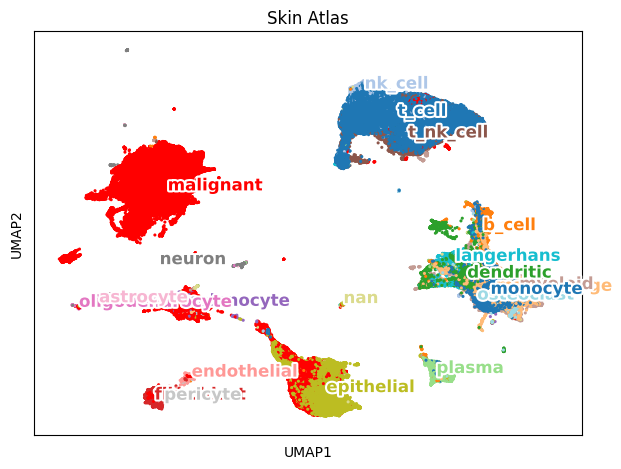

<Figure size 1000x800 with 0 Axes>

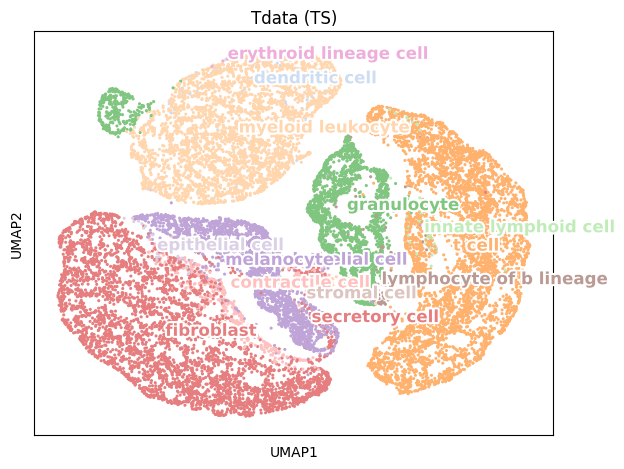

<Figure size 1000x800 with 0 Axes>

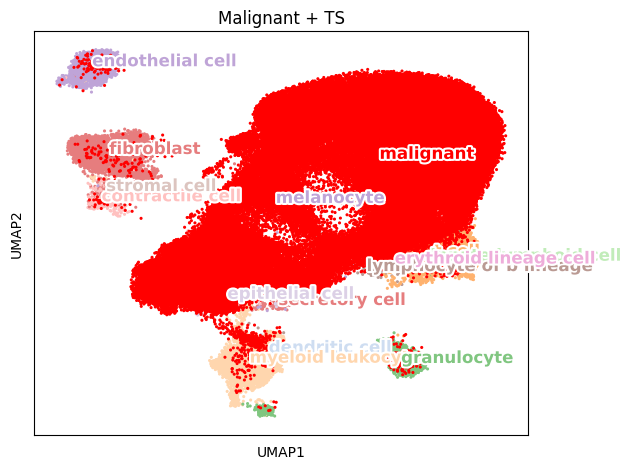

In [53]:
plot_umap_with_labels(skin,   'broad_cell_class_norm', color_map,         'Skin Atlas')
plot_umap_with_labels(tdata,  'broad_cell_class_norm', tdata_color_map,   'Tdata (TS)')
plot_umap_with_labels(mal_ts, 'broad_cell_class_norm', mal_ts_color_dict, 'Malignant + TS')